In [1]:
options(warn= -1)
library(roperators)
library(readr)
library(tidyr)
library(ggplot2)
library(magrittr)
library(tidyverse)
library(purrr)
library(lattice)
library(plotly)
library(grid)
library(gridExtra)
library(lattice)
library(ggplotify)
library(cowplot)
library(plyr)
library(dplyr)
library(quantmod) 
library(scales)
library(MASS)
library(epiDisplay)


Attaching package: 'ggplot2'

The following object is masked from 'package:roperators':

    %+%


Attaching package: 'magrittr'

The following object is masked from 'package:tidyr':

    extract

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v tibble  3.0.3     v stringr 1.4.0
v purrr   0.3.4     v forcats 0.5.0
v dplyr   1.0.0     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x ggplot2::%+%()      masks roperators::%+%()
x magrittr::extract() masks tidyr::extract()
x dplyr::filter()     masks stats::filter()
x dplyr::lag()        masks stats::lag()
x purrr::set_names()  masks magrittr::set_names()

Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

# Introduction

This notebook presents data analysis for my graduate thesis, 'Fused Silica Cherenkov Detector Response to MeV Photons'. The project investigated the quartz Cherenkov radiation detector's response to a monoenergetic photon beam in ~15MeV to 55 MeV energy ranging. The efficiency defined the response characteristics by calculating the fraction of events interacted with the quartz detector. Detailed physics theories, experiment setup, analysis, and conclusion of this study can be find in my graduate thesis published in the following link:

https://mspace.lib.umanitoba.ca/handle/1993/35272

The study conducted monte carlo simulation using Geant4 toolkit (https://geant4.web.cern.ch/node/1) for particle interaction through matter simulation. Simulation result was benchmarked at Mainz Microtron (MAMI) hall A2 during beamtime (https://www.blogs.uni-mainz.de/fb08-nuclear-physics/accelerators-mami-mesa/the-mainz-microtron/). 

# Parameters

In [2]:
#data file directory
dir <- c("D:/ch00", 
         "D:/ch02",
         "D:/ch04",
         "D:/ch06")

#plot breaks for every 10^n
# breaks <- c(0, 10^1, 10^2, 10^3, 10^4, 10^5, 
#             10^6, 10^7, 10^8, 10^9, 10^10, 
#             10^11, 10^12, 10^13, 10^14)
# breaks <- c(10, 10^2, 10^3, 10^4)

#data run numbers
run<-10942:10964

#beam energies
energy <- c(21.06, 22.11, 23.80, 25.85, 15.43, 
            17.52, 18.21, 20.31, 26.58, 28.60, 
            29.30, 31.30, 32.00, 34.00, 34.60, 
            39.20, 41.80, 44.30, 46.80, 49.30, 
            51.70, 54.10, 56.40)

#Dataframe for run numbers and its corresponding energies
df_run_eng <- data.frame(
  run = run,
  energy = energy
)

#set working directory
setwd(dir[1])

# MAMI Beamtime Experiment

The four detectors in the experiment are quartz, lyso, trigger left, and trigger right. Full experiment setup, particle interaction theories, detector properties and electronics principles are explained throughout chapter 2 and 3 of the thesis. 

The LYSO detector serves as a calorimeter with assumed 100 percent efficiency. Therefore, all the photons in the photon beam are expected to interact with the LYSO detector. Any photons that might deviate from the LYSO trajectory are expected to be detected in either of the triggers. Therefore, the total number of events is determined based on the number of events recorded in the LYSO or triggers. 

The quartz detector response is characterized by efficiency, calculated based on the number of responses relative to the determined total number of events.

## Merging Data Files into a Single Frame

The experiment and data acquisition setup can be found in thesis figure 3.5 and figure 3.8. Each detector is coupled with a photomultiplier tube(PMT) which records the response in terms of ADC values. Detectors were connected to different Data Acquisition(DAQ) channels, and events were recorded in chronological order with an assigned event number. Therefore, for every beam energies, each detector dataset were merged by matching the event numbers.

Corresponding detector DAQ channels are:

00    Quartz

02    Trigger Right

04    Trigger Left

06    LYSO

Merged detector datas should return a dataframe similar to the example below:

    event     Trigger.Right     Trigger.Left     Quartz   LYSO

     1        123               234               234     1235

     2        234               345               237     356

     3        NA                223               232     454

In [3]:
##write a function to read the raw data files and select event numbers and corresponding 
##ADC channel column named after the corresponding detectors

#creates dataframe such as:
###event Quartz
###  1    234
###  2    237
###  3    232

df_create_det <- function(dir, run, chan)
{
  # This function reads a detector ADC output file for 
  # a specific energy run. The run is identified by the 
  # run number passed by run and stored in runnum
  
  #Set the work directory passed by dir
  setwd(dir)
    
  # identify the detector by the assigned channel number
  if(chan == "00"){
      det <- "Quartz"
  }
  if(chan == "02"){
      det <- "Trigger.Right"
  }
if(chan == "04"){
      det <- "Trigger.Left"
  }
if(chan == "06"){
      det <- "LYSO"
  }
  # Get the file name and read the file as a dataframe
  runnum <- df_run_eng[run,1] %>% toString()
  filename <- paste("run_", runnum, "_ch", chan,".dat", sep = "")
    
      # For pedestal run
      if(run == -1)
        {
       filename <- paste("run_10965_ch", chan,".dat", sep = "")      
         }

  df<-read.table(filename)
  df <- df[,c(1, 4)]   
  df <- as.data.frame(df )
  colnames(df) <- c("event", det)
  
  # Return a detector dataframe
  df
}

# Merge the detectors dataframes into a single dataframe
# by matching the event numbers across the detectors
# one dataframe is created for each run
# runind is energy run index in df_run_eng

# Example dataframe:
###event Trigger.Right Trigger.Left Quartz 
###  1        123          234        234
###  2        234          345        237
###  3        NA           223        232

df_merg_dets <- function(runind)
{
    #read the data files from all the detectors for a given run
    df_qz <- df_create_det(dir[1], runind, "00")
    df_tr <- df_create_det(dir[2], runind, "02")
    df_tl <- df_create_det(dir[3], runind, "04")
    df_lyso <- df_create_det(dir[4], runind, "06")

    #Match the event numbers across the detectors
    df <- inner_join(df_tr, df_tl) %>% 
          inner_join(df_qz) %>% 
          inner_join(df_lyso)

    #return the merged dataframe
    return(df)
}


## Data Cleaning Procedures

The cleaning process is critical to remove the environmental noises from the real events. In addition to the 23 beam energies, one additional dataset was taken without exposing the experiment setup to a photon beam. This particular data is called the pedestal data, taken to record background noises. 

While the pedestal analysis is sufficient for data cleaning, LYSO datasets require one additional procedure to determine the maximum ADC channel value due to the detector pile up effect. A brief description of the pile up effect is written in the second paragraph of page 51 of the linked thesis. 

### Pedestal Analysis - Determining Pedestal Cuts

The pedestal analysis determines a cut to remove noise-prone channels. Such 'pedestal cuts' are assigned for each detectors. 

In [4]:
#create pedestal dataframe and remove event column
df_ped <- df_merg_dets(-1)
df_ped_noeve <- df_ped[-1]
head(df_ped_noeve)

Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


Trigger.Right,Trigger.Left,Quartz,LYSO
223,130,162,119
222,130,161,120
222,129,159,120
222,129,160,119
223,130,160,119
223,129,160,125


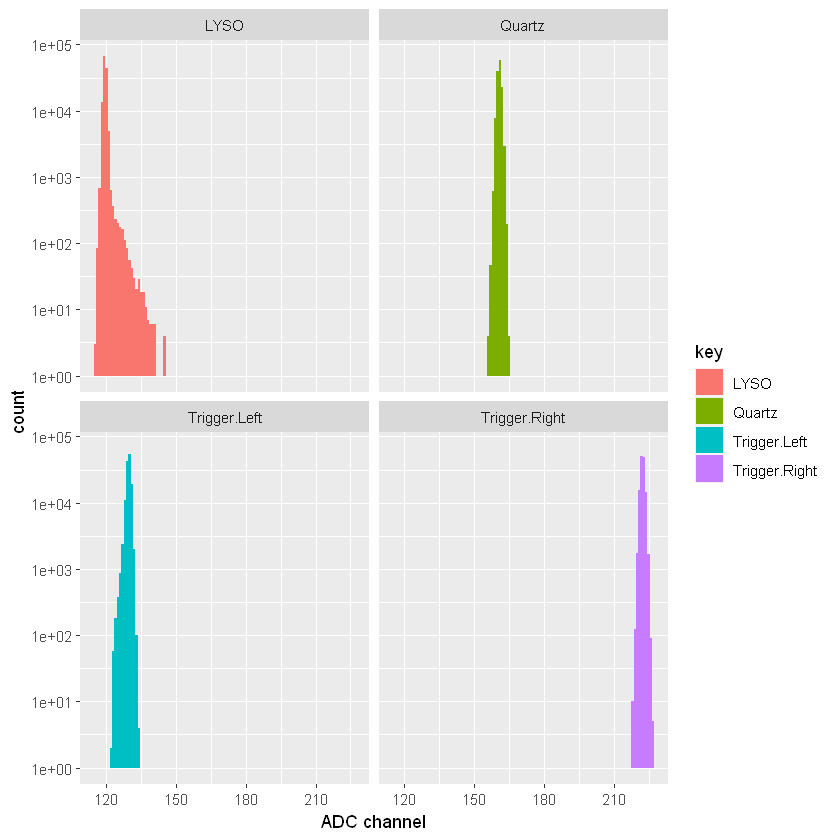

In [5]:
# Plot the pedestal histogram

df_ped_gthr <- gather(df_ped_noeve)
plt_ped <- ggplot(df_ped_gthr) + 
    geom_histogram(aes(value, fill = key), binwidth = 1) + 
    facet_wrap(~key) +
    theme_grey() + 
    labs(x = "ADC channel") +
    scale_y_continuous(trans= 'log', breaks = scales::trans_breaks("log10", function(x) 10^x)) 
plt_ped

The above plots show distribution of the pedestal data in each detectors. The distributions are expected to appear throughout the beam energy plots, as they arise from an environmental background noise. To verify, the plots are superimposed with the beam energy plots from low, mid, and high energies. The selected energies are 18.21 MeV, 24.6 MeV, and 54.1 MeV.

In [6]:
# Assinging dataframes for 18.21 MeV, 24.6 MeV, 54.1 MeV, 
# and pedesetal plots. Assign a new Energy column. 
# Merging the data frames
df_5 <- df_merg_dets(5) %>% mutate(Energy = df_run_eng[5,2])
df_15 <- df_merg_dets(15) %>% mutate(Energy= df_run_eng[15,2])
df_23 <- df_merg_dets(23) %>% mutate(Energy = df_run_eng[23,2])
df_ped_eng <- df_ped  %>% mutate(Energy = "Pedestal")

df_erg_and_ped <- do.call("rbind", list(df_5, df_15, df_23, df_ped_eng))
head(df_erg_and_ped)

Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


event,Trigger.Right,Trigger.Left,Quartz,LYSO,Energy
1,228,133,165,289,15.43
2,228,133,166,1270,15.43
3,227,131,164,212,15.43
4,226,132,164,308,15.43
5,225,132,164,387,15.43
6,229,132,165,316,15.43


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


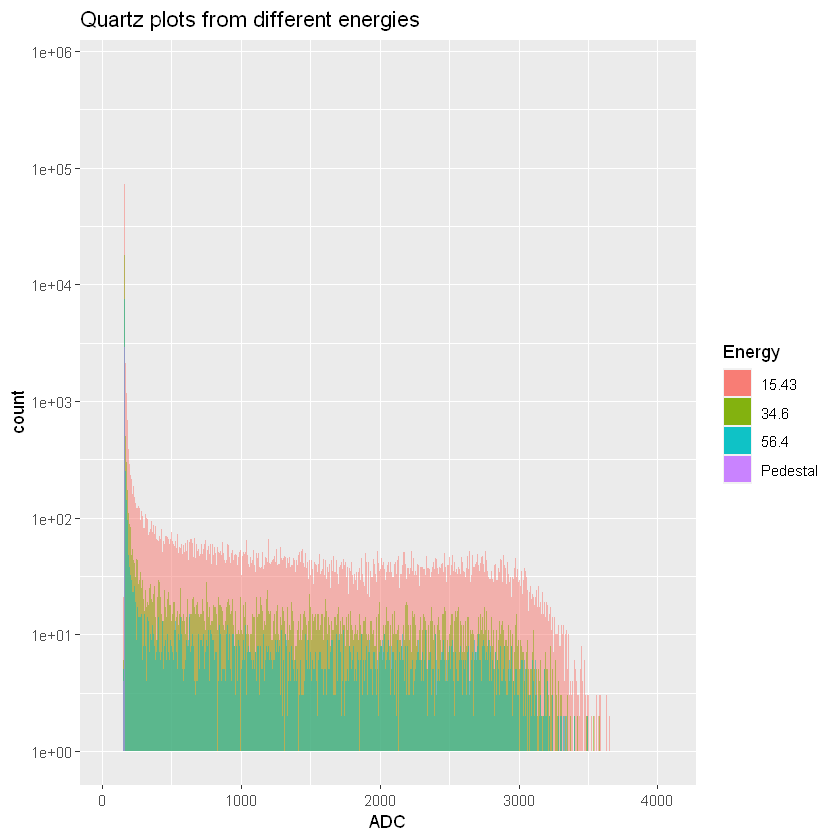

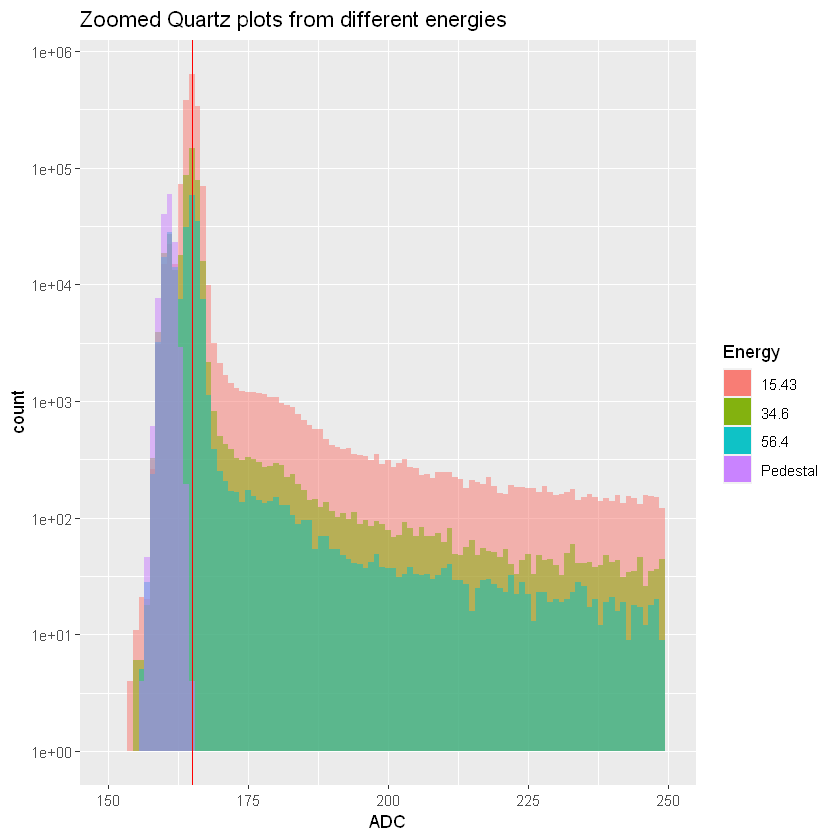

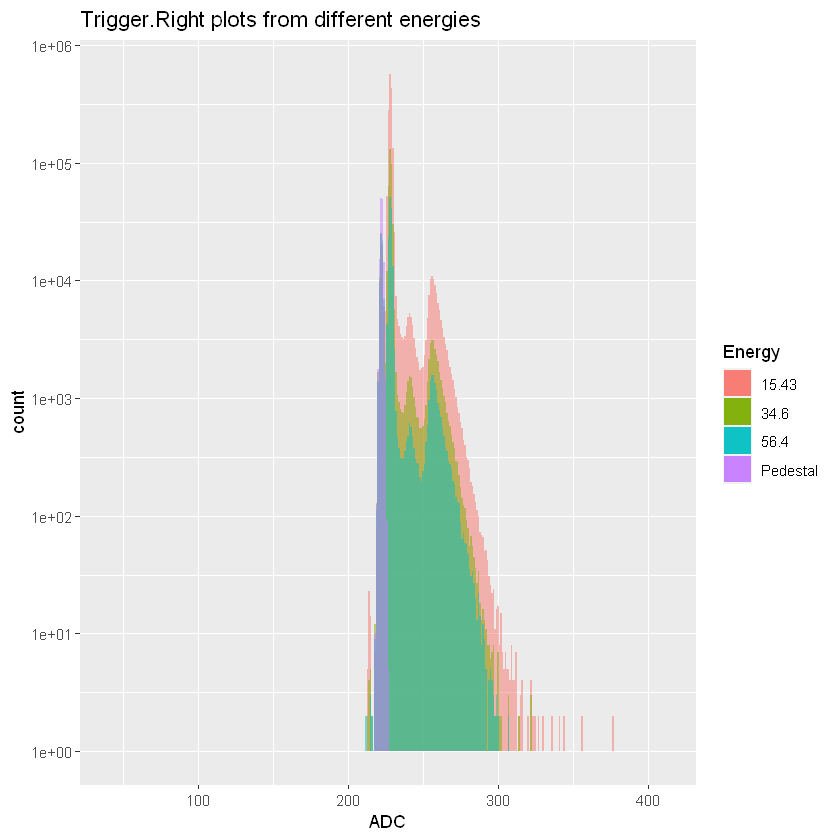

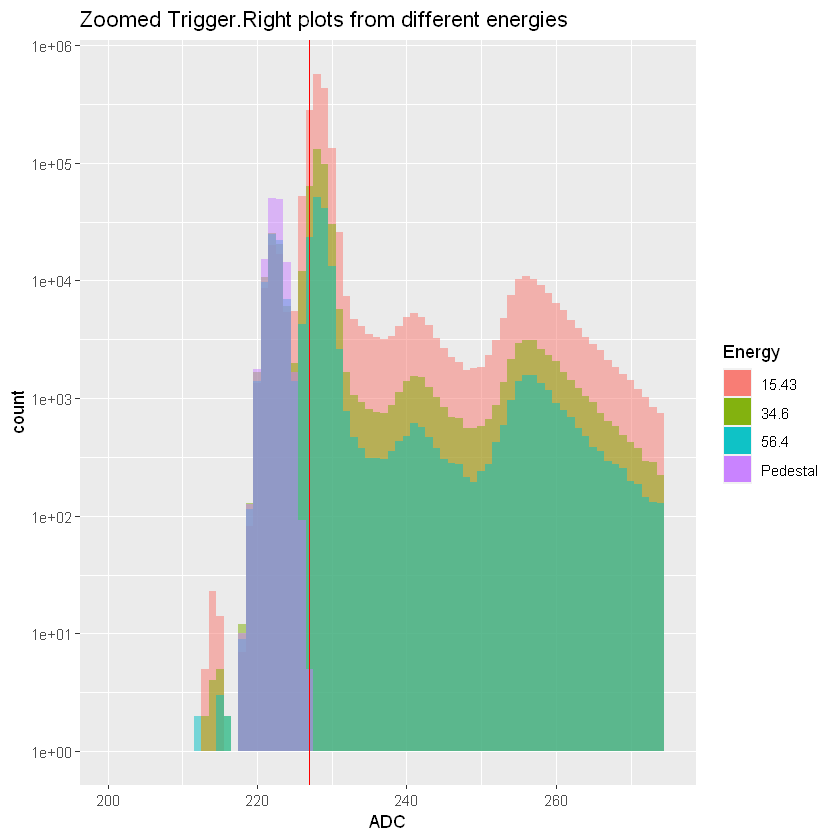

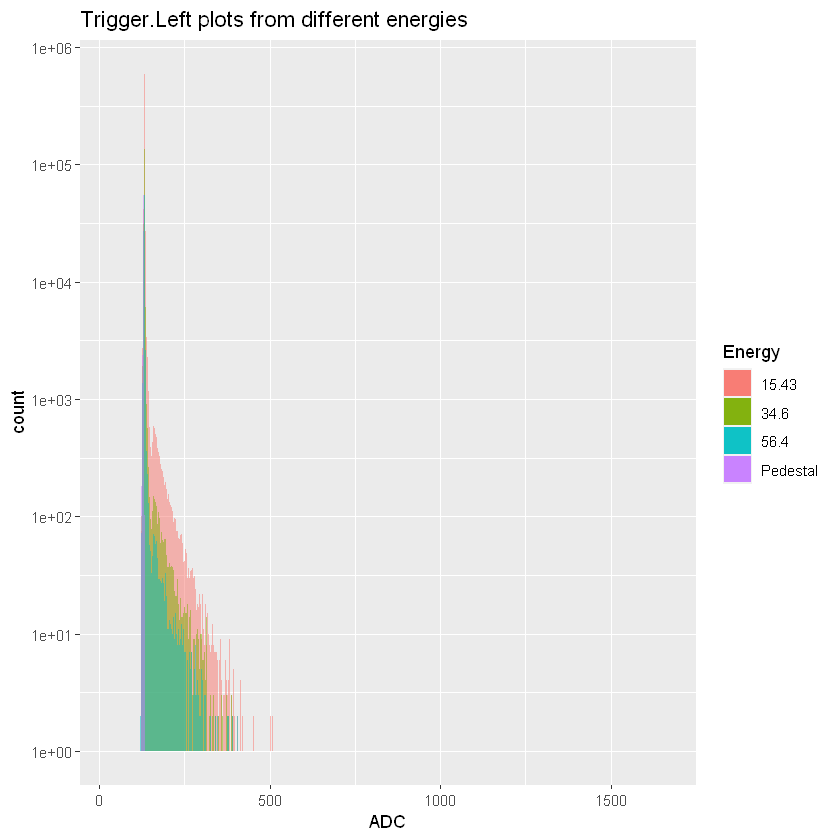

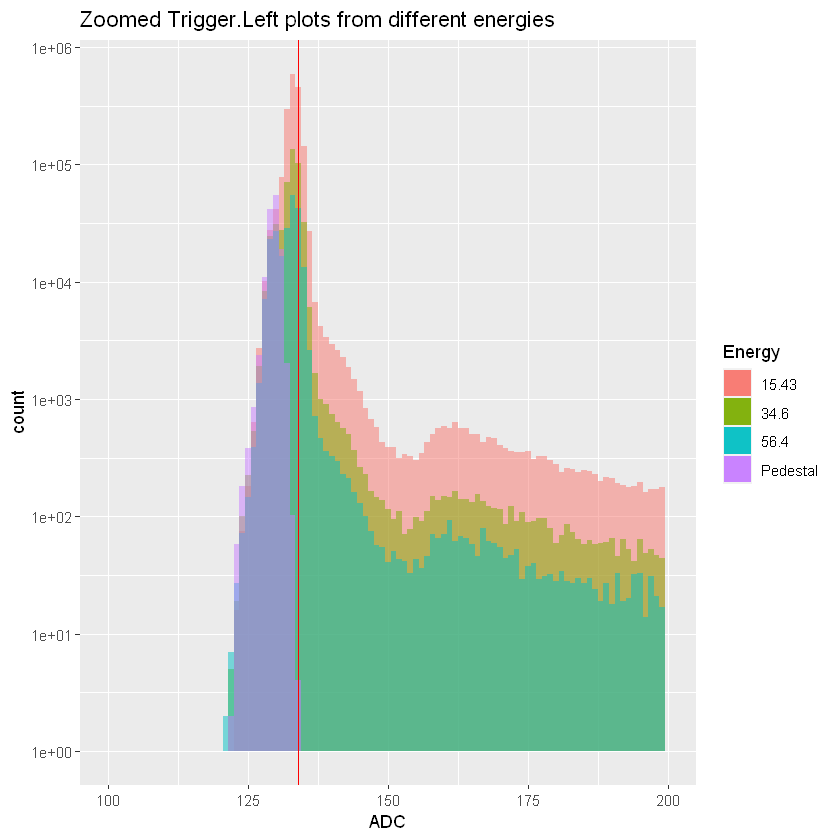

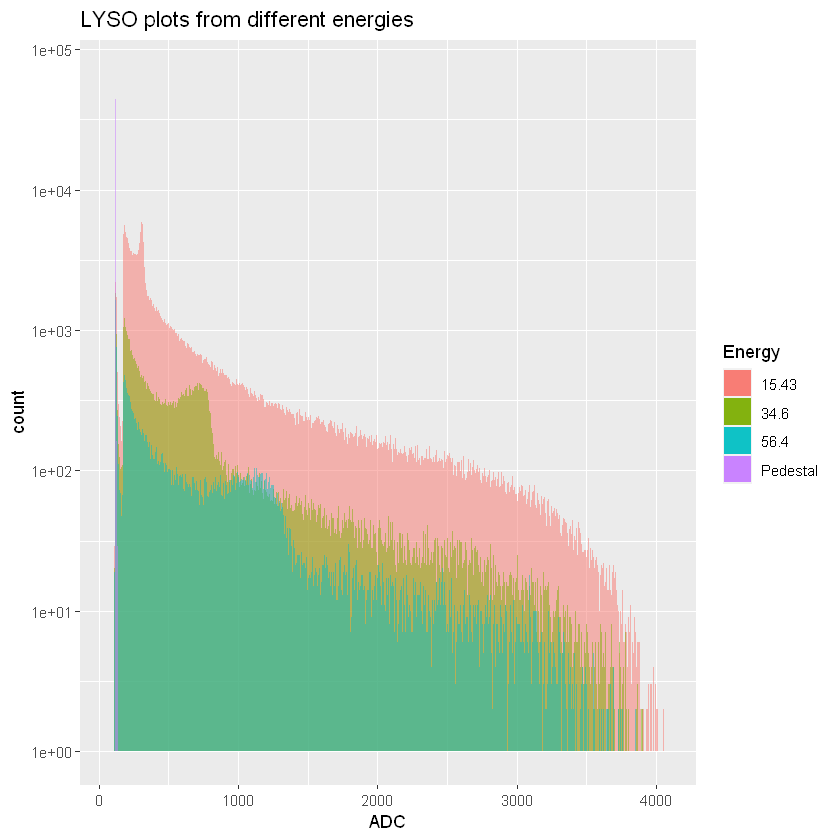

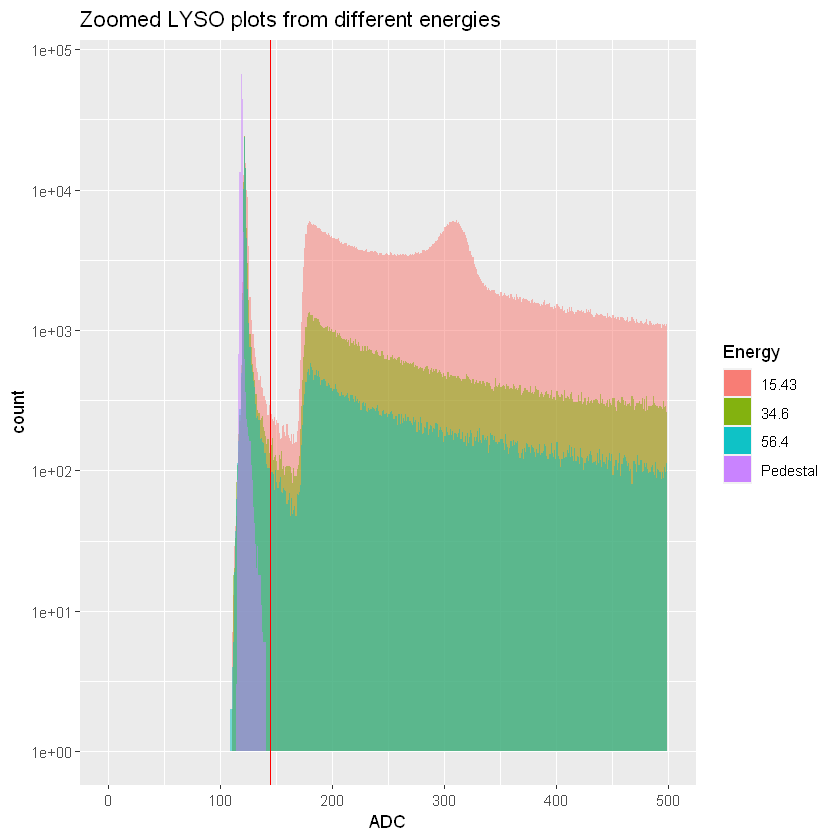

In [7]:
plt_det_eng<-function(df, det){
            
        p <- ggplot(df, aes(x = eval(parse(text=det)), group = Energy, fill = Energy)) + 
                geom_histogram(data = subset(df, Energy == df_run_eng[5,2]), binwidth = 1, alpha = 0.5) +
                geom_histogram(data = subset(df, Energy == df_run_eng[15,2]), binwidth = 1, alpha = 0.5) +
                geom_histogram(data = subset(df, Energy == df_run_eng[23,2]), binwidth = 1, alpha = 0.5) +
                geom_histogram(data = subset(df_erg_and_ped, Energy == 'Pedestal'), binwidth = 1, alpha = 0.5) +
                scale_y_continuous(trans= 'log', breaks = scales::trans_breaks("log10", function(x) 10^x)) +
                theme_grey() +
                labs(title = paste(det, " plots from different energies", sep = ""), x = "ADC")
        p
}

plt_det_eng_ped <-function(df, det, xint, lim_low, lim_high){
        p <- ggplot(df, aes(x = eval(parse(text=det)), group = Energy, fill = Energy)) + 
                geom_histogram(data = subset(df, Energy == df_run_eng[5,2]), binwidth = 1, alpha = 0.5) +
                geom_histogram(data = subset(df, Energy == df_run_eng[15,2]), binwidth = 1, alpha = 0.5) +
                geom_histogram(data = subset(df, Energy == df_run_eng[23,2]), binwidth = 1, alpha = 0.5) +
                geom_histogram(data = subset(df_erg_and_ped, Energy == 'Pedestal'), binwidth = 1, alpha = 0.5) +
                scale_y_continuous(trans= 'log', breaks = scales::trans_breaks("log10", function(x) 10^x)) +
                scale_x_continuous(breaks = seq(0, 2000, 50)) +
                theme_grey() +
                geom_vline(xintercept = xint, color = 'red') +
                xlim(lim_low, lim_high) +
                labs(title = paste("Zoomed ",det, " plots from different energies", sep = ""), x = "ADC")
       p                                                                        
}

qz_det <- "Quartz"
qz_xline <- 165
qz_xmin <- 150                                                                               
qz_xmax <- 250                                                                               

tr_r_det <- "Trigger.Right"
tr_r_xline <- 227
tr_r_xmin <- 200                                                                               
tr_r_xmax <- 275                                                                               

tr_l_det <- "Trigger.Left"
tr_l_xline <- 134
tr_l_xmin <- 100                                                                               
tr_l_xmax <- 200                                                                               

lyso_det <- "LYSO"
lyso_xline <- 145
lyso_xmin <- 0                                                                               
lyso_xmax <- 500                                                                               
                                                                               
qz_plt <- plt_det_eng(df_erg_and_ped, qz_det)
qz_plt_ped <- plt_det_eng_ped(df_erg_and_ped, qz_det, qz_xline, qz_xmin, qz_xmax)                                                                           

tr_r_plt <- plt_det_eng(df_erg_and_ped, tr_r_det)
tr_r_plt_ped <- plt_det_eng_ped(df_erg_and_ped, tr_r_det, tr_r_xline, tr_r_xmin, tr_r_xmax)                                                                           

tr_l_plt <- plt_det_eng(df_erg_and_ped, tr_l_det)
tr_l_plt_ped <- plt_det_eng_ped(df_erg_and_ped, tr_l_det, tr_l_xline, tr_l_xmin, tr_l_xmax)                                                                           

lyso_plt <- plt_det_eng(df_erg_and_ped, lyso_det)
lyso_plt_ped <- plt_det_eng_ped(df_erg_and_ped, lyso_det, lyso_xline, lyso_xmin, lyso_xmax)                                                                           

qz_plt
qz_plt_ped

tr_r_plt
tr_r_plt_ped
                                                                               
tr_l_plt
tr_l_plt_ped

lyso_plt
lyso_plt_ped


The above plot shows clear the pedestal distribution appearing in all of the selected energy plots. Because the energies range from the lowest to the highest beam energy, the pedestal conclusively appears throughout the entire energy range. Therefore, the signals appearing in the pedestal ADC channels are a background noise subject to data cleaning. 

To remove the noise-prone ADC channels, pedestal cuts are determined as the highest ADC channel from the pedestal distribution. Any signals below the cuts will be removed from the datasets. 


In [8]:
#in order of quartz, trigger right, trigger left, and LYSO
ped_cuts <- c(165, 227, 134, 145)

## Determining LYSO upper limit

The second peak in the LYSO histogram is called the photopeak. The photopeak is formed from a complete deposition of particle energy. Thus, events appearing past the photopeak are considered to be a noise presumably due to the pileup effect. 

The LYSO upper limit is determined from locating the photopeak and deciding the uppermost photopeak channel. Once the photopeak is located, the gaussian distribution is modeled based on the photopeak dispersion. The upper limit is determined as one standard deviation away from the highest point of the photopeak. 

In [9]:
# Create dataframes for LYSO data with pedestal cut applied
df_lyso_flt <- function(run_ind){
    #This function creates a LYSO dataframe 
    #with pedestal cut applied

    dir <- dir[4]
    chan <- "06"
    runnum <- df_run_eng[run_ind,1]
    eng <- df_run_eng[run_ind,2]
    cut <- ped_cuts[4]
    
    
    lyso_org <- df_create_det(dir, run_ind, chan)
    df_lyso_flt <-filter(lyso_org, LYSO > ped_cuts)
    df_lyso_flt
    }

lyso_fun_p_or_df <- function(run_ind, rtrn){
    
    dir <- dir[4]
    chan <- "06"
    runnum <- df_run_eng[run_ind,1]
    eng <- df_run_eng[run_ind,2]
    cut <- ped_cuts[4]
    
    
    # Locating the photopeak
    df_lyso_flt<-df_lyso_flt(run_ind)
    d <- density(df_lyso_flt$LYSO)
    pks <- findPeaks(d$y)
    len <- length(pks)
    max <- pks[length(pks)]
    photopk <- d$x[max]
    
    while(photopk > 1450)
    {
      max <- pks[len-1]
      photopk <- d$x[max]
      len <- len - 1
    }
    photopk <- d$x[max]
    
    # Defining the gaussian modeling range depending on the run number/energy
    if(runnum < 10953){
        df_rng <- as.data.frame(filter(df_lyso_flt, LYSO > photopk - 80, 
                                    LYSO < photopk + 80)) 
      }
      if(runnum >= 10953 & runnum < 10962){
        df_rng <- as.data.frame(filter(df_lyso_flt, LYSO > photopk - 200, 
                                    LYSO < photopk + 200)) 
      } 
      if(runnum >= 10962 & runnum < 10965) {
        df_rng <- as.data.frame(filter(df_lyso_flt, LYSO > photopk - 300, 
                                    LYSO < photopk + 300)) 
      }
   
   # Model the normal distribution
   # Define statistical measures based on the fitted model
   lyso_rng <- df_rng$LYSO
   fit.param <-fitdistr(df_rng$LYSO, "normal")
  
   sd <- fit.param$estimate[2][["sd"]]
   mean <- fit.param$estimate[1][["mean"]]
   n <- length(df_rng$LYSO)
   bn_wdth <- 5

    
   # Plot the LYSO events along with the gaussian model
      p <-  ggplot(df_lyso_flt) +
        geom_histogram(aes(LYSO), binwidth = bn_wdth, fill = "orange") +
        stat_function( 
          fun = function(x, mean, sd, n, bw){ 
            dnorm(x = x, mean = mean, sd = sd) * n * bw
          }, 
          args = c(mean = mean, sd = sd, n = n, bw = bn_wdth), color = "lightblue") +
        geom_vline(xintercept = photopk, color = "red") +
        geom_vline(xintercept = photopk + sd, color = "blue") +
        scale_x_continuous(breaks=seq(0, 4000, 500)) +
        xlim(0,1500)+
        labs(title = paste(eng," MeV LYSO Photopeak Gaussian fit"), x = "ADC") +
        theme_grey()
    # Create dataframe with statistical summaries
      lyso_df <- data.frame(matrix(ncol = 5, nrow = 0))

      row <- c(runnum, eng, round(photopk) , round(sd) , round(photopk) + round(sd))
      lyso_df <- rbind(lyso_df, row)
      df_colnames <- c("run", "Energy", "Photopeak", "Standard.Deviation", "Max.Photopeak")
      colnames(lyso_df) <- df_colnames
    
    if(rtrn == 'p'){
         p
    }
    
    else if (rtrn == 'df'){
        lyso_df
    }
    else{
        print("invalid rtrn input. Enter p for plot and df for dataframe")
    }
    
    
}



Below code shows the LYSO real event spectrums. To examin the plots for all photon energies run the first two lines.
Otherwise, execute the last two lines for selective plots. You can modify ls_lyso_spect_slct to specify energies. Numbers in the below list parameters are the index numbers in energy parameter defined in the second cell.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


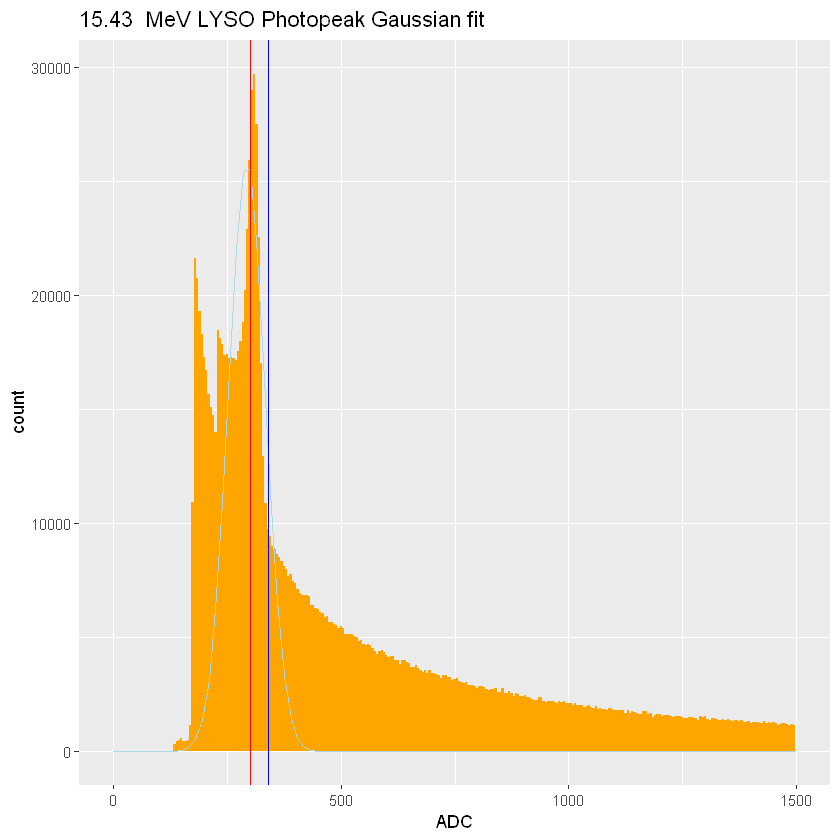

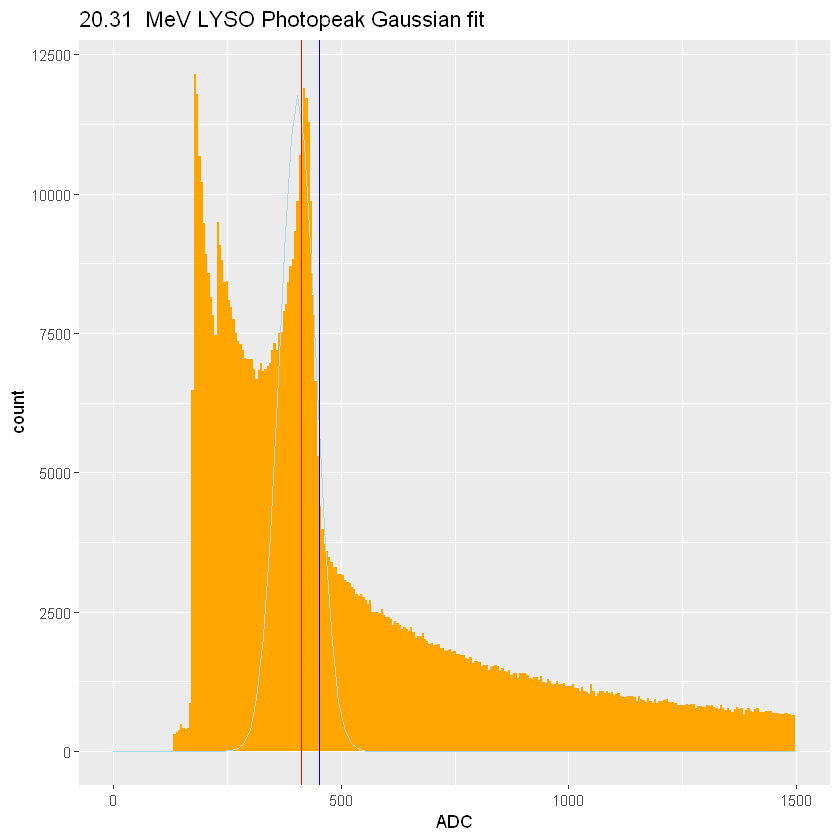

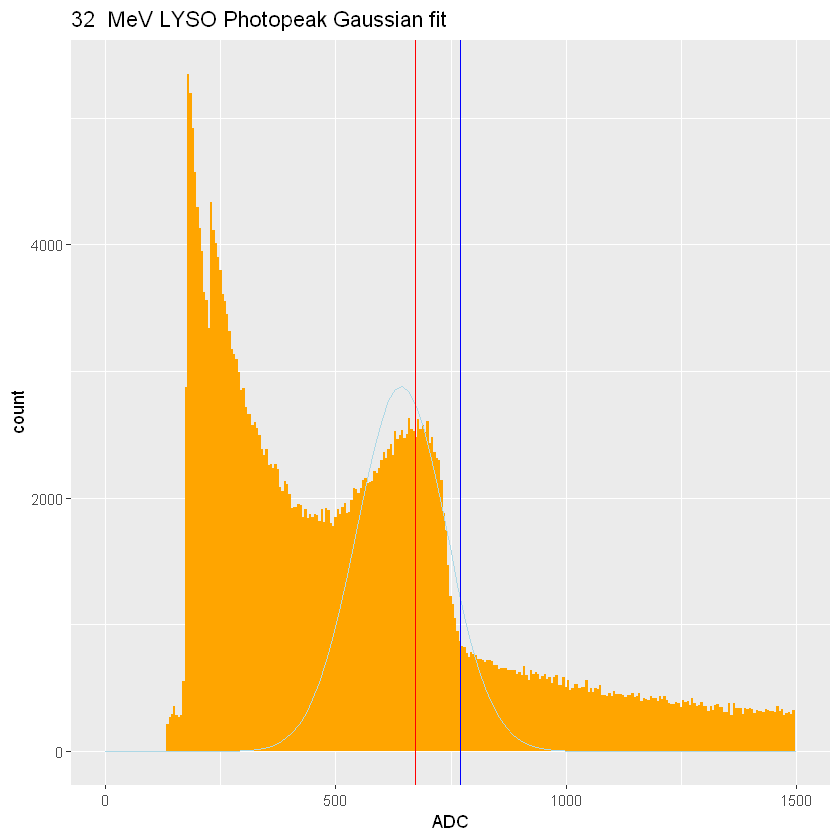

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


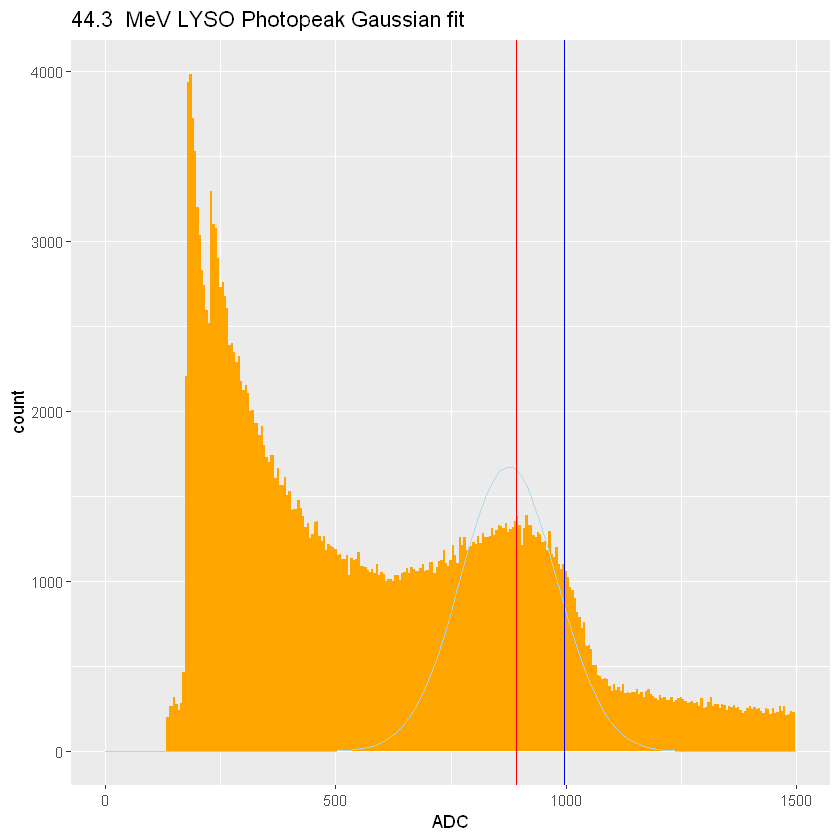

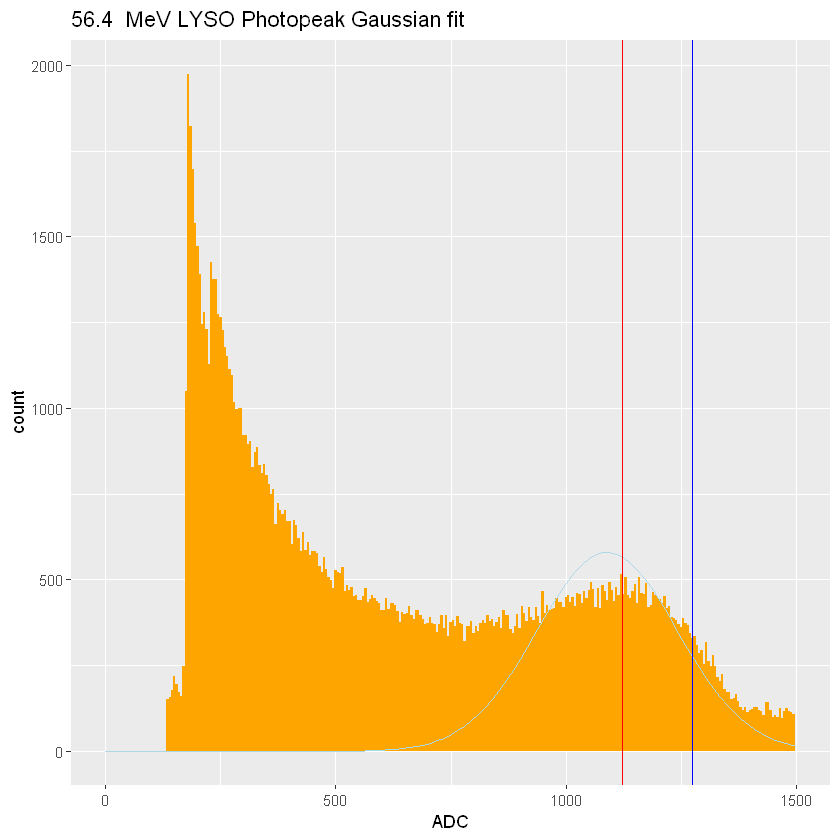

In [10]:
# ls_lyso_spect_all <- 1:23
# lapply(ls_lyso_spect_all,lyso_fun_p_or_df,rtrn='p')

ls_lyso_spect_all <- c(5, 8, 13, 18, 23)
lapply(ls_lyso_spect_all,lyso_fun_p_or_df,rtrn='p')


### Photopeak Error Analysis


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which wil

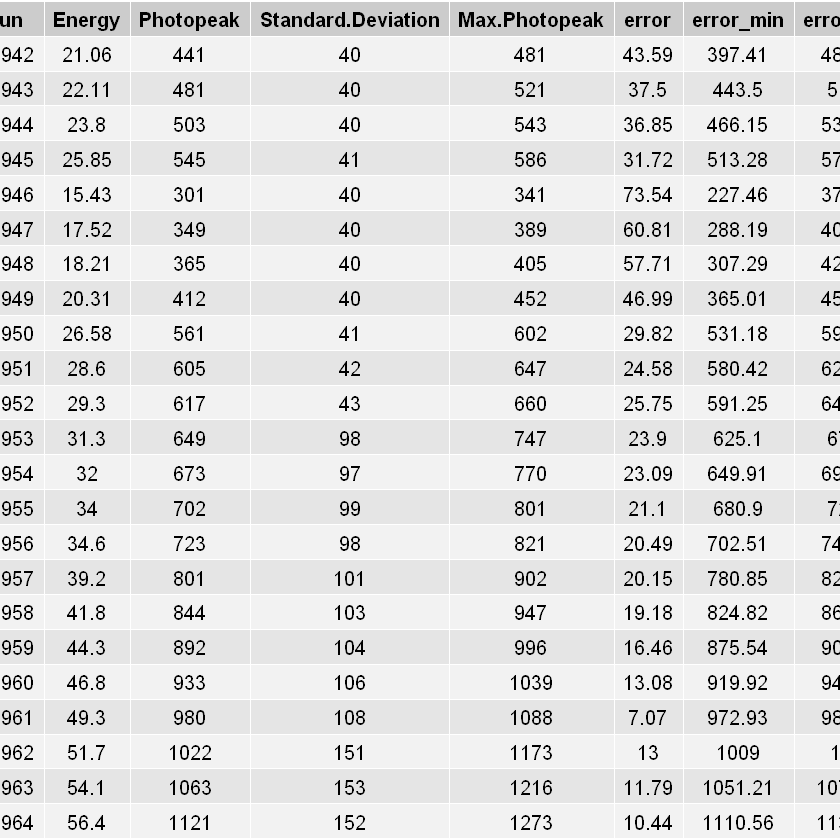

In [11]:
# Estimate the level of error

lyso_smmry_df <- data.frame(matrix(ncol = 5, nrow = 0))
df_colnames <- c("run", "Energy", "Photopeak", "Standard.Deviation", "Max.Photopeak")
colnames(lyso_smmry_df) <- df_colnames
for(i in 1:23)
{
  ex <- lyso_fun_p_or_df(i,'df')
  lyso_smmry_df <-rbind(lyso_smmry_df ,ex)
}
lyso_df_srt <- lyso_smmry_df[order(energy), ]

pk_frq<-c()
for(i in 1:23){
    df_cnt<-df_lyso_flt(i)$LYSO%>%count()
    df_pk<-df_cnt%>%subset(x==lyso_smmry_df[i,3])
    frq<-df_pk$freq%>%int()
    pk_frq<-append(pk_frq, frq)    
}
pk_err<-sqrt(pk_frq)%>%round(2)
df_cnt<-df_lyso_flt(1)$LYSO%>%count()

lyso_smmry_df$error<-pk_err
lyso_smmry_df$error_min<-lyso_smmry_df$Photopeak-lyso_smmry_df$error
lyso_smmry_df$error_max<-lyso_smmry_df$Photopeak+lyso_smmry_df$error
grid.table(lyso_smmry_df)

## Photopeak vs Energy Linearity

The photopeak appears in later channel with increasing photon beam energy. Thus, a linearity between the photopeak and corresponding energy is expected. 


Call:
lm(formula = Energy ~ Photopeak, data = lyso_smmry_df)

Coefficients:
(Intercept)    Photopeak  
   -1.64478      0.05147  


`geom_smooth()` using formula 'y ~ x'


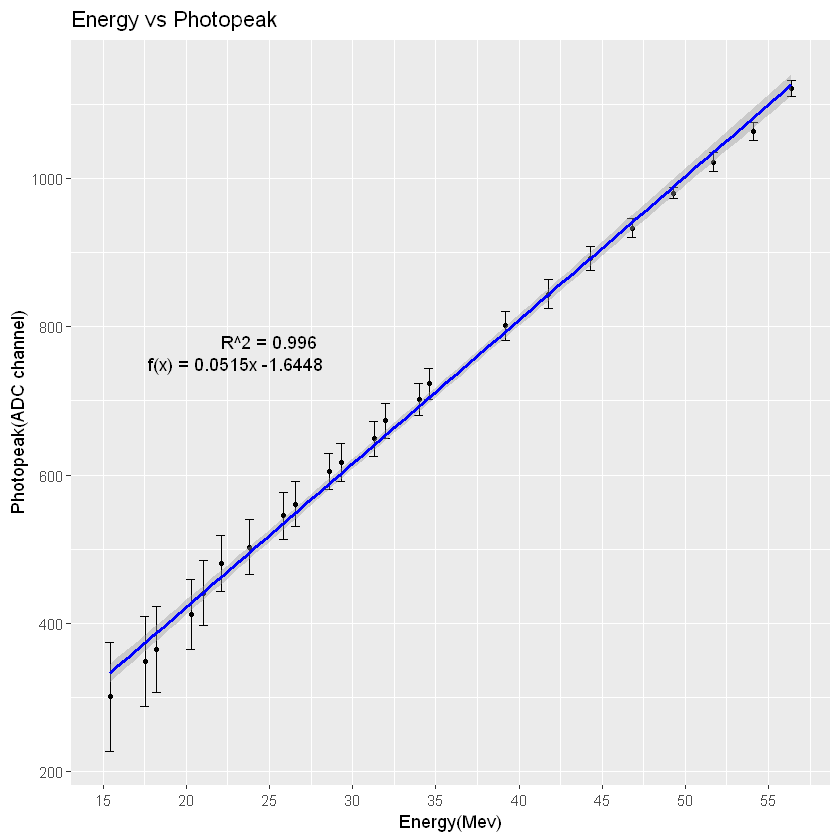

In [12]:
# Create a linear model based on the LYSO photopeak and its energy
lyso_lm <- lm(Energy~Photopeak, lyso_smmry_df)

lyso_lm

# Determine the statistical properties based on the linear model
intrcpt<-lyso_lm$coefficients[1]%>%round(4)
slope<-lyso_lm$coefficients[2]%>%round(4)
r2<-summary(lyso_lm)$r.squared %>%round(4)

photopeak_plt <- ggplot(lyso_smmry_df,aes(x = Energy, y = Photopeak)) + 
    geom_point(size = 1) +
    geom_errorbar(aes(ymin = error_min, ymax = error_max)) +
    # geom_point(aes(color = Standard.Deviation), size = 4) +
    stat_smooth(method = "lm", col = "blue") +
    scale_x_continuous(breaks=seq(0, 60, 5)) +
    labs(title = "Energy vs Photopeak", x = "Energy(Mev)", y = "Photopeak(ADC channel)") + 
    annotate("text", x = 23 , y = 750, label = paste("f(x) = " , slope, "x ", intrcpt, sep = "")) +
    annotate("text", x = 25, y = 780, label = paste("R^2 = ", r2, sep = "")) +
    theme_grey()

photopeak_plt

# Determining the real events 

The real events are determined based on the pedestal cuts and LYSO upper limits. Two conditions must be met in order for an event to be considered real:

    1. Must contain a detector signal above the pedestal value.
    2. For a LYSO signal the value must be between the pedestal cut and upper limit.

The quartz signals are examined based on the determined real events. 

## Quartz spectrum before and after the cuts

In [13]:
df_bf_af <- function(run_ind){
    # This function returns a dataframe for a given run index
    # Containing events before and after the cuts
    df_org <- df_merg_dets(run_ind) %>% mutate(cut = "Before")
    df_cut <- filter(df_org, 
                     Trigger.Right > ped_cuts[2] 
                     | Trigger.Left > ped_cuts[3] 
                     | (LYSO > ped_cuts[4] & LYSO < lyso_df_srt[run_ind, 5])) %>% mutate(cut = "After") 
    df_bf_af <- rbind(df_org, df_cut)
    df_bf_af$cut <- as.factor(df_bf_af$cut)
    return(df_bf_af)
    }

In [14]:
# qz_bfaf_plt <- function(df, runind){
#     # This function plots the quartz spectrum before and after the cuts
#     eng <- df_run_eng[runind, 2]
#     p <- ggplot(df) +
#        geom_histogram(data = subset(df, cut == "Before"), aes(Quartz, fill = cut), 
#                       alpha = 1., binwidth = 1) +
#        geom_histogram(data = subset(df, cut == "After"), aes(Quartz, fill = cut), 
#                       alpha = 1., binwidth = 1) +
#        theme_grey() +
#        scale_y_continuous(trans = 'log', breaks = trans_breaks("log", function(x) 10^x)) +
#        scale_x_continuous(breaks = seq(0,4000,100)) +
#        labs(title = paste("Quartz spectrum before and after cut: ", eng, " MeV", sep = ""), 
#             x = "ADC",
#             y = "log(count)")
    
#     p
# }

Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


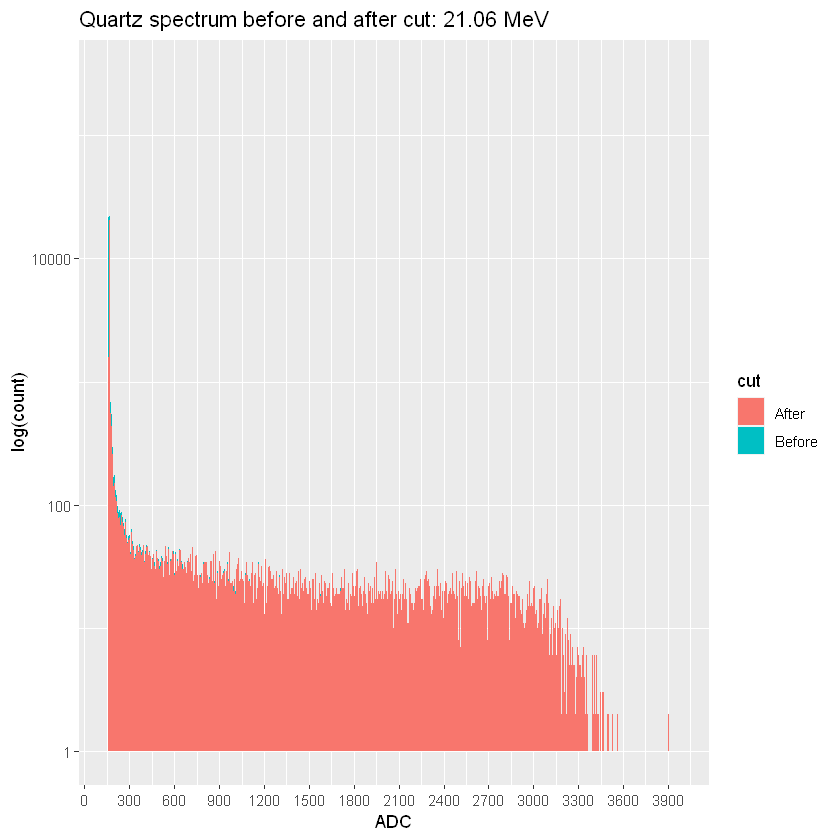

Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


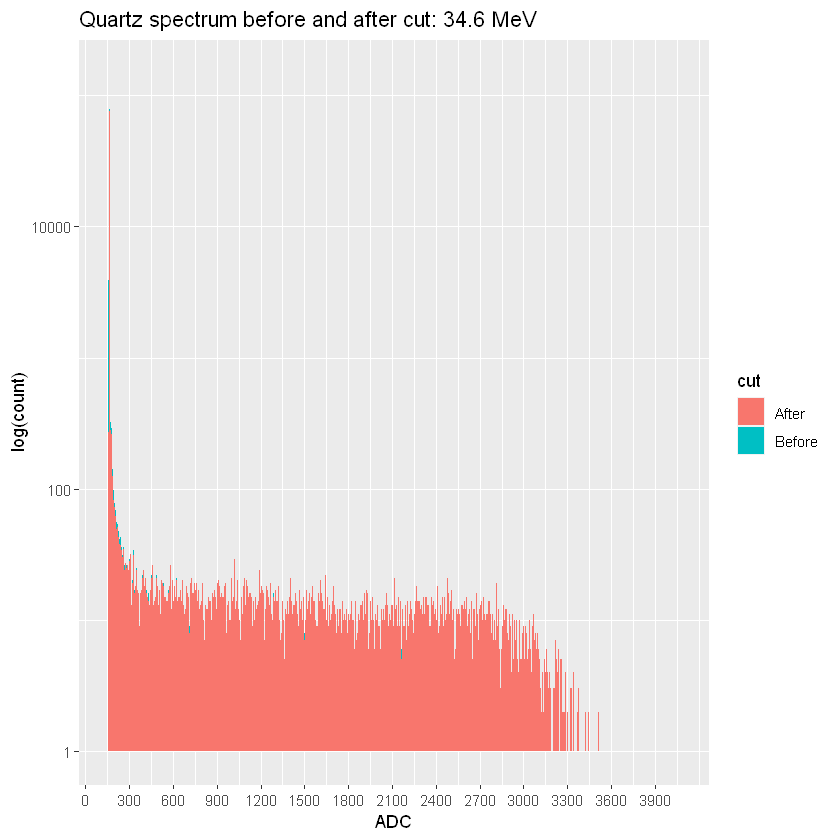

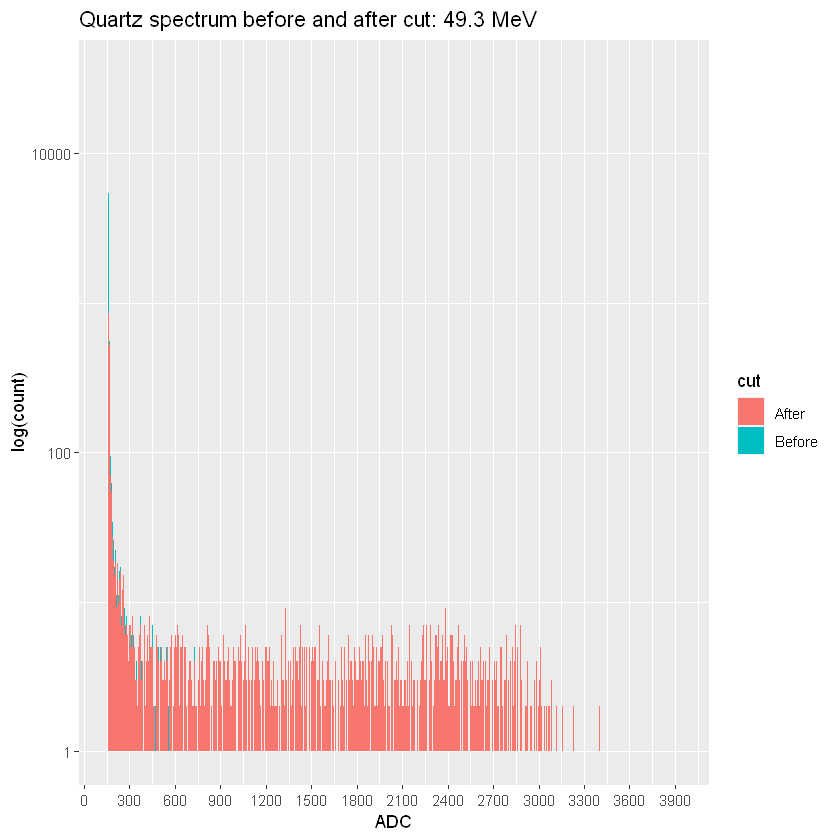

In [15]:
bfaf_plt<-function(i){
    df <-df_bf_af(i)
    eng <- df_run_eng[i, 2]
    p <- ggplot(df) +
       geom_histogram(data = subset(df, cut == "Before"), aes(Quartz, fill = cut), 
                      alpha = 1., binwidth = 1) +
       geom_histogram(data = subset(df, cut == "After"), aes(Quartz, fill = cut), 
                      alpha = 1., binwidth = 1) +
       theme_grey() +
       scale_y_continuous(trans = 'log', breaks = trans_breaks("log", function(x) 10^x)) +
       scale_x_continuous(breaks = seq(0,4000,300)) +
       labs(title = paste("Quartz spectrum before and after cut: ", eng, " MeV", sep = ""), 
            x = "ADC",
            y = "log(count)")
    p
}
                
bfaf_plt(1)
bfaf_plt(15)
bfaf_plt(20)


The overall number of events decreased after the cuts, notably in early channels.

## Density plots

The event distribution is better shown in the following density plots. The shift in density after applying the cuts is apparent throughout the energies.

Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


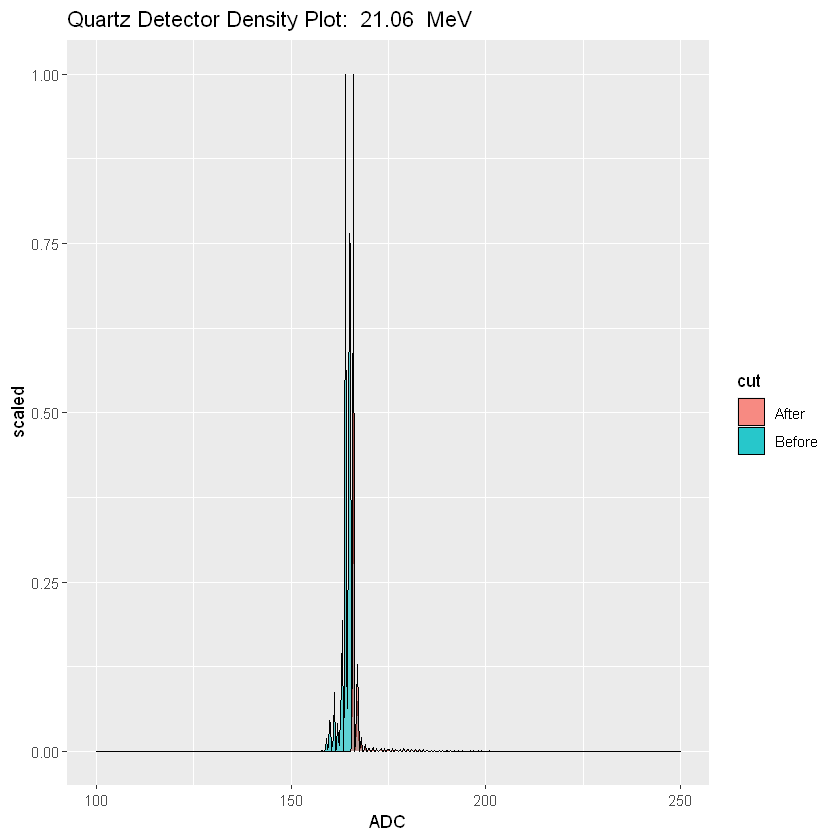

Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


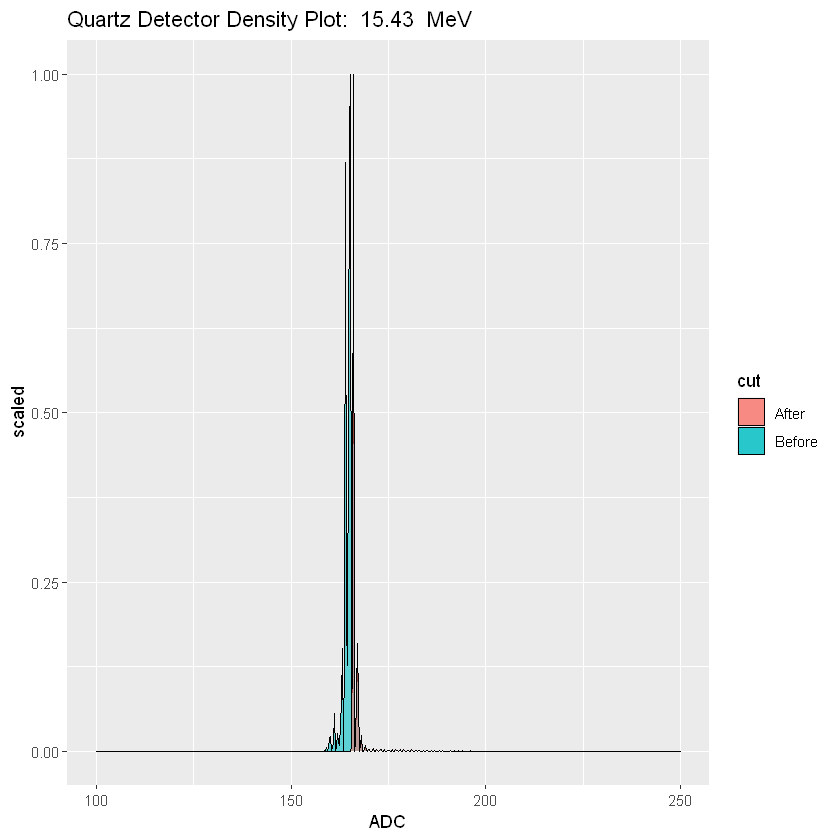

Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


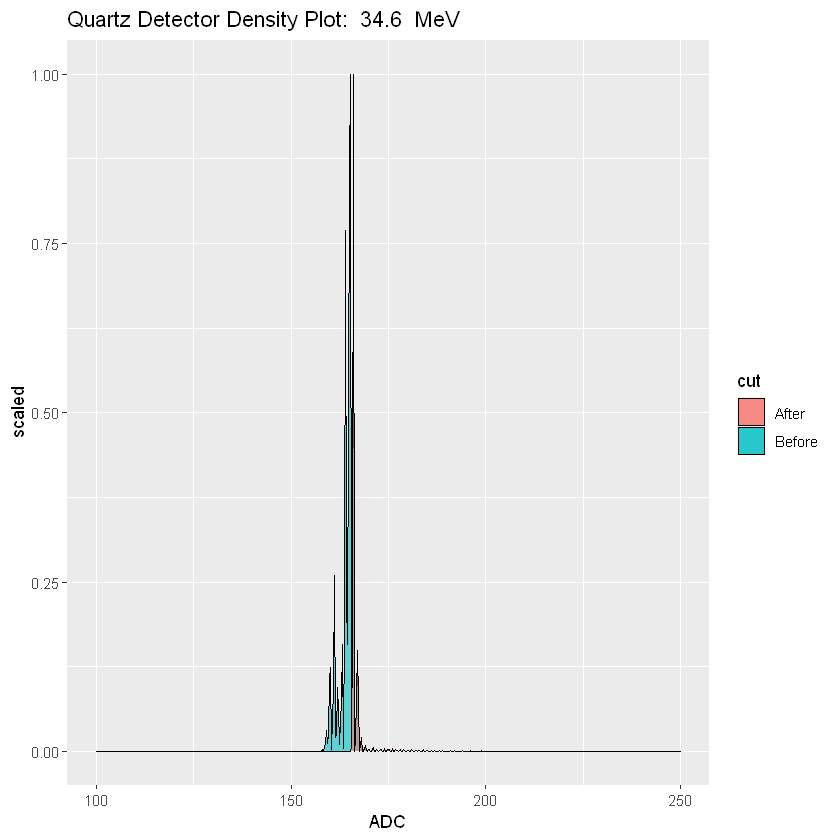

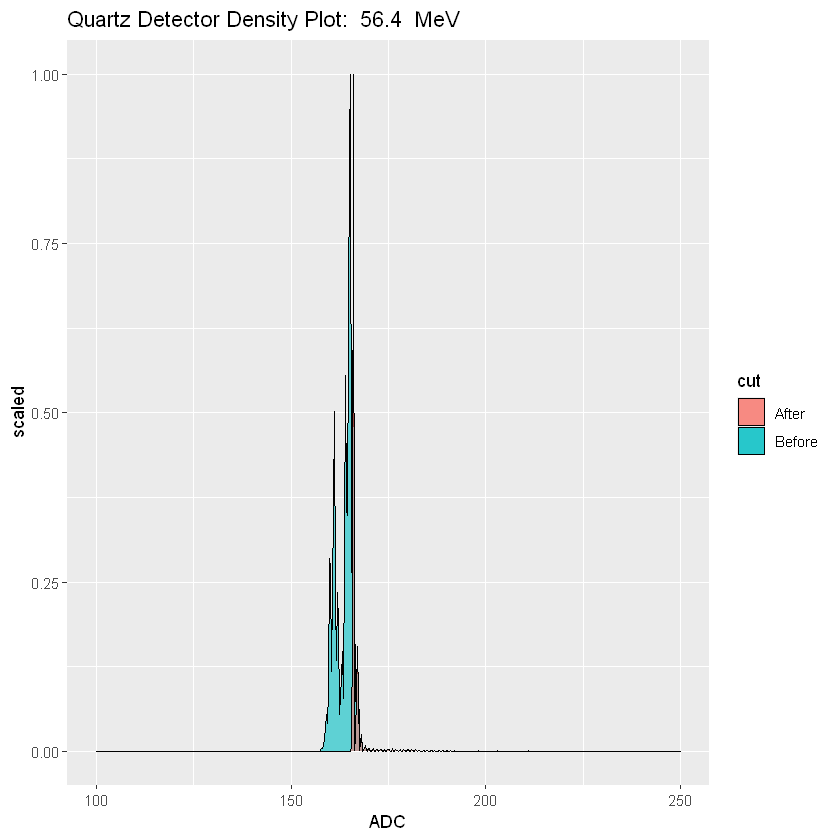

In [16]:
den_plt<-function(i, xmin, xmax){
    
    df <- df_bf_af(i)
    p <- ggplot(df) +
    geom_density(data = subset(df, cut == "Before"), aes(Quartz,fill = cut,  ..scaled..),
                 binwidth = 1, alpha = 0.6) +
    geom_density(data = subset(df, cut == "After" & Quartz > 165), 
                 aes(Quartz, fill = cut, ..scaled..), binwidth = 1, alpha = 0.6) +
    scale_x_continuous(name = "ADC", limit = c(xmin, xmax)) +
     labs(title = paste("Quartz Detector Density Plot: ", df_run_eng[i, 2], " MeV")) +
    theme_grey()
   
    p
}


den_plt(1,100,250)
den_plt(5,100,250)
den_plt(15,100,250)
den_plt(23,100,250)

# Photon Efficiency

The photon interaction with quartz is characterized by photon efficiency. The efficiency is calculated for each nunber of photoelectrons produced inside of PMT arising from a single optical photon. Once the total number of event is determined, ADC values are converted to the photoelectron numbers using the conversion factor derived from the PMT calibration. Efficiency is calculated by dividing the count for each n number of photoelectrons by the total number of event. 

## Conversion factor based on PMT Calibration

In [17]:
## Calculate the ADC channels to PE numbers conversion factor
## Based on the local PMT Calibration
pCperPE<-2.29
pCperChan<-0.2

ADC_to_PE_conv<-pCperPE/pCperChan
print(paste("the conversion factor is ",ADC_to_PE_conv, sep=""))

[1] "the conversion factor is 11.45"


## Calculating the photoelectron efficiency

In [18]:

df_cut <- function(run_ind){
    
    # This function applies the cuts to the original merged dataframe
    
    org_df <- df_merg_dets(run_ind) 
    cut_df <- filter(org_df, Trigger.Right > ped_cuts[2] 
                     | Trigger.Left > ped_cuts[3] 
                     | (LYSO > ped_cuts[4] & LYSO < lyso_df_srt[run_ind, 5]))
                              
    cut_df
}

df_cut_qz <- function(cut_df){
    
    # This function returns Quartz column from the merged dataframe
    # Recommended to input the 'cleaned' dataframe
    
    cut_qz_df <- filter(cut_df, 
                        Quartz > ped_cuts[1]) %>% dplyr::select(Quartz) 
                              
    cut_qz_df
}

cut_eff_df <- function(run_ind, nPE, PEtab){
    
    # This function converts the ADC values to photoelectron numbers
    # As well as corresponding efficiencies and error estimates
    # To return the dataframe with efficiency set PEtab = 0
    # To return the dataframe with photoelectron counts set PEtab = 1
    
    cut_df <- df_cut(run_ind)
    cut_qz_df <- df_cut_qz(cut_df)

    eve_cnt <- nrow(cut_df)
    
    #multiply the ADC to PE conversion factor to desired nPE
    chan_per_pe <- ADC_to_PE_conv * nPE
    qz_flt <- cut_qz_df / chan_per_pe
    head(qz_flt)
    
    #calibrate the number of PE to account pedestal
    qz_flt <- ceiling(qz_flt - floor(min(qz_flt)))
    #qz_flt <- (qz_flt - floor(min(qz_flt)))  %>% mutate(round = nPE * ceiling(Quartz))
    
    #count PE by the number of PE
    pe_cnt <- count(qz_flt) 
    colnames(pe_cnt)<- c("Photoelectrons", "count")
    pe_cnt$Photoelectrons <- pe_cnt$Photoelectrons * nPE
    
    #maximum number of PE
    pe_cnt_rw <- nrow(pe_cnt)
    if(PEtab == 1)
        {
            return(pe_cnt)
    }   
    
    mat_eff <- matrix(nrow = 0, ncol = 3)
    df_eff <- as.data.frame(mat_eff)
    colnames(df_eff) <- c("Photoelectrons", "Efficiency", "error")

    for(i in 1:pe_cnt_rw){
        #store PE number in df_eff dataframe
        df_eff[i,1] <- pe_cnt[i,1] 
        
        #calculate efficiency and store it in df_eff dataframe
        eve_tot <- sum(pe_cnt[,2])
        sig_eve_tot <- sqrt(eve_tot)
        
        cnt_per_pe <- pe_cnt[i,2]
        sig_cnt_per_pe <- sqrt(cnt_per_pe)
        
        eff <- cnt_per_pe / eve_tot
        
        
        df_eff[i,2] <- eff  
        
        err <- (((sig_eve_tot / eve_tot)^2 + (sig_cnt_per_pe/cnt_per_pe)^2) %>% sqrt()) * eff
        df_eff[i,3] <- err  
        }
    
    df_eff <- df_eff%>% mutate(ymin = Efficiency - error, ymax = Efficiency + error)
    
    return(df_eff)
}

In [19]:
test_qz_count <- cut_eff_df(1, 2, 0)
test_pe_count <- cut_eff_df(1, 2, 1)
head(test_qz_count)
head(test_pe_count)


Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


Photoelectrons,Efficiency,error,ymin,ymax
2,0.652484780,0.0021576216,0.650327159,0.654642402
4,0.017905099,0.0002805197,0.017624579,0.018185619
6,0.010008203,0.0002089113,0.009799292,0.010217115
8,0.007266526,0.0001777694,0.007088756,0.007444295
10,0.006083502,0.0001625606,0.005920942,0.006246063
12,0.005401321,0.0001531232,0.005248198,0.005554444


Photoelectrons,count
2,151122
4,4147
6,2318
8,1683
10,1409
12,1251


##  Plotting Photoelectron Efficiencies

In [20]:
plt_eff <- function(df, runid){
    
    # This function plots the photoelectron efficiencies
    
    p <- ggplot(df, aes(x = Photoelectrons, y = Efficiency)) + 
        geom_point(size = 0.5) +
        geom_errorbar(aes(ymin = ymin, ymax = ymax)) +
        theme_grey() +
        scale_x_continuous(breaks = seq(0, 350, 20)) +
        scale_y_continuous(trans = 'log',
                           breaks = scales::trans_breaks("log10", 
                                            function(x) 10^x)) +
        labs(title = paste("Efficiency with ", 
                           nPE, 
                           " photoelectron binning for ", 
                           df_run_eng[runid,2], 
                           " MeV gamma-ray", sep = ""),
            y = "log(Efficiency)") 

    return(p)
}


In [21]:
# Bind efficiency dataframe into a one dataframe 
nPE <- 2
PEtab <- 0
                                                         
mat_eff_all <- matrix(nrow = 0, ncol = 6)
df_eff_all <- as.data.frame(mat_eff_all)
colnames(df_eff_all) <- c("Photoelectrons", "Efficiency", 
                          "error", "ymin", 
                          "ymax", "Energy")

for (i in 1:23){
    runid <- i

    tab <- cut_eff_df(runid, nPE, PEtab) %>% mutate(Energy = df_run_eng[runid,2])
    df_eff_all <- rbind(df_eff_all, tab)
    runid
}

tail(df_eff_all)

Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, b

,Photoelectrons,Efficiency,error,ymin,ymax,Energy
3773,306,1.569982e-05,1.569994e-05,-1.232417e-10,3.139976e-05,56.4
3774,308,1.569982e-05,1.569994e-05,-1.232417e-10,3.139976e-05,56.4
3775,310,3.139964e-05,2.220325e-05,9.196393e-06,5.360289e-05,56.4
3776,318,3.139964e-05,2.220325e-05,9.196393e-06,5.360289e-05,56.4
3777,320,1.569982e-05,1.569994e-05,-1.232417e-10,3.139976e-05,56.4
3778,322,1.569982e-05,1.569994e-05,-1.232417e-10,3.139976e-05,56.4


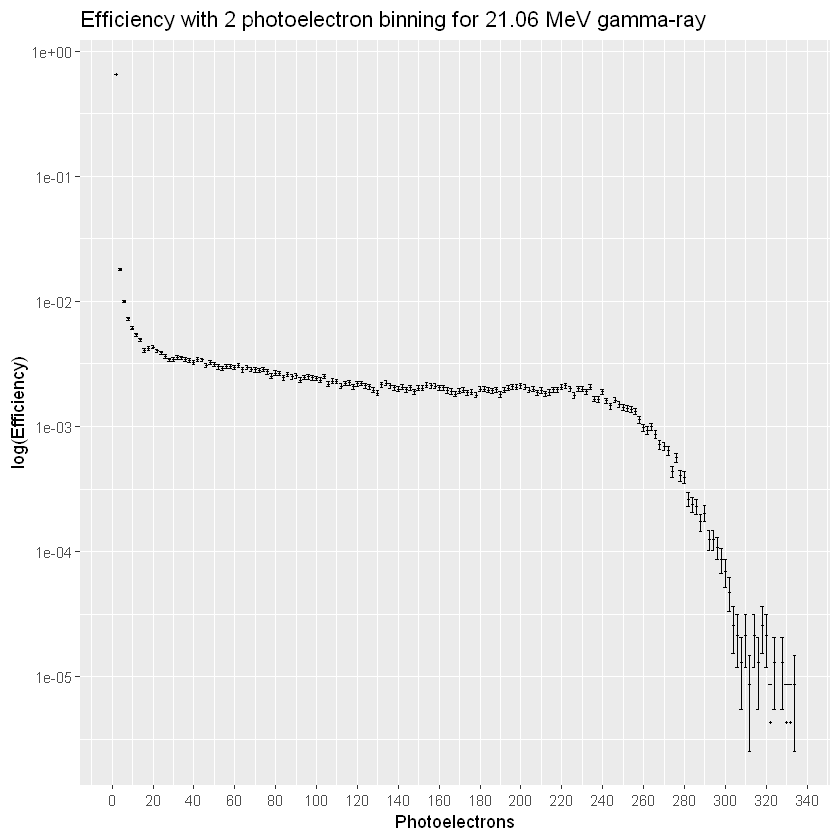

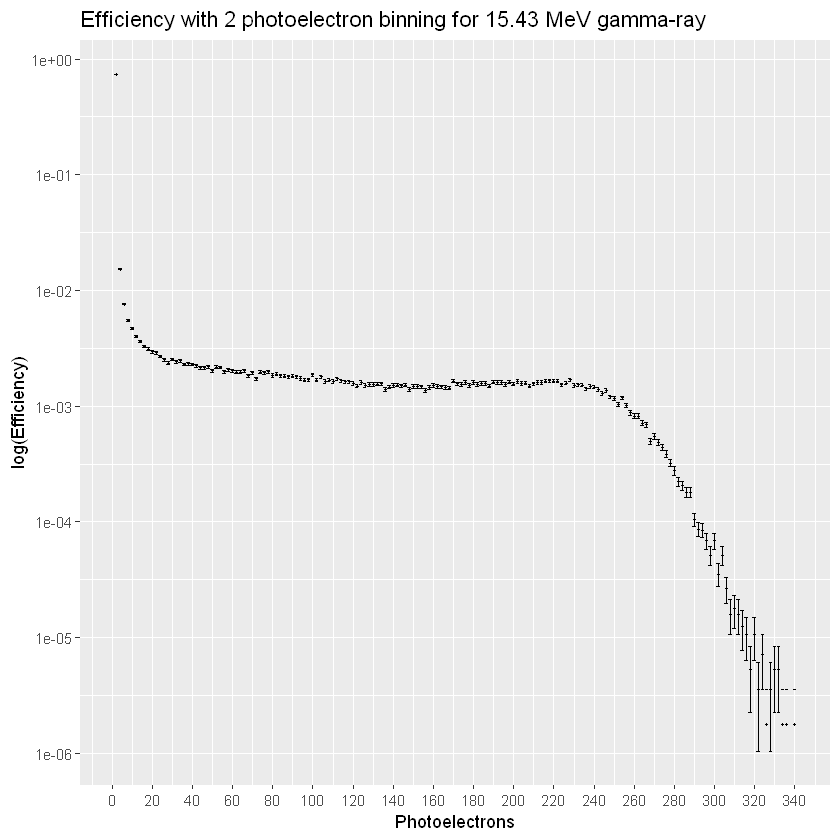

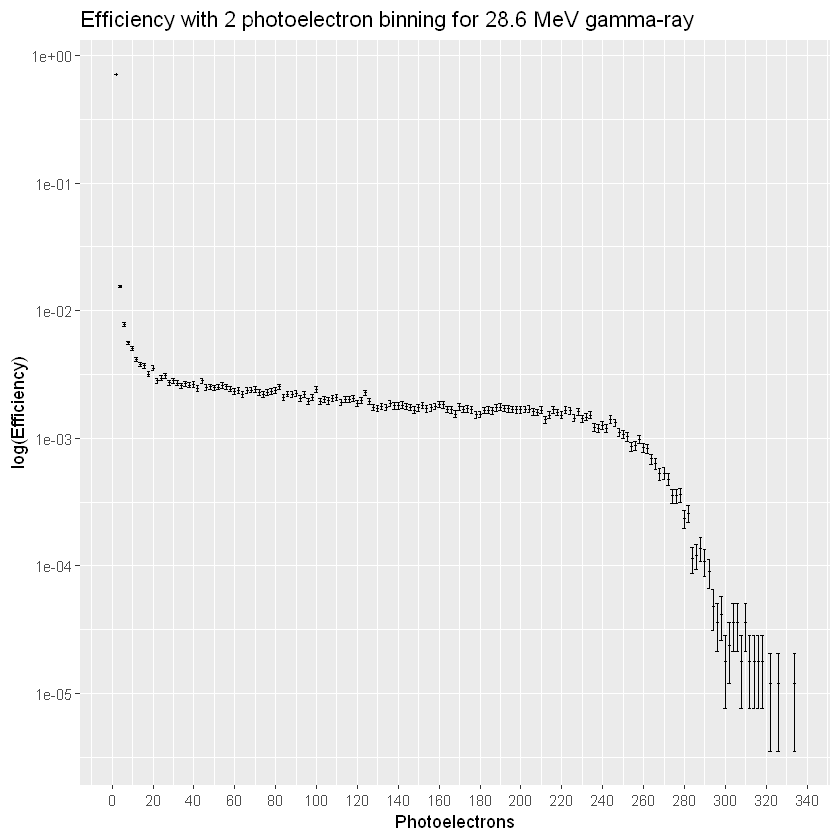

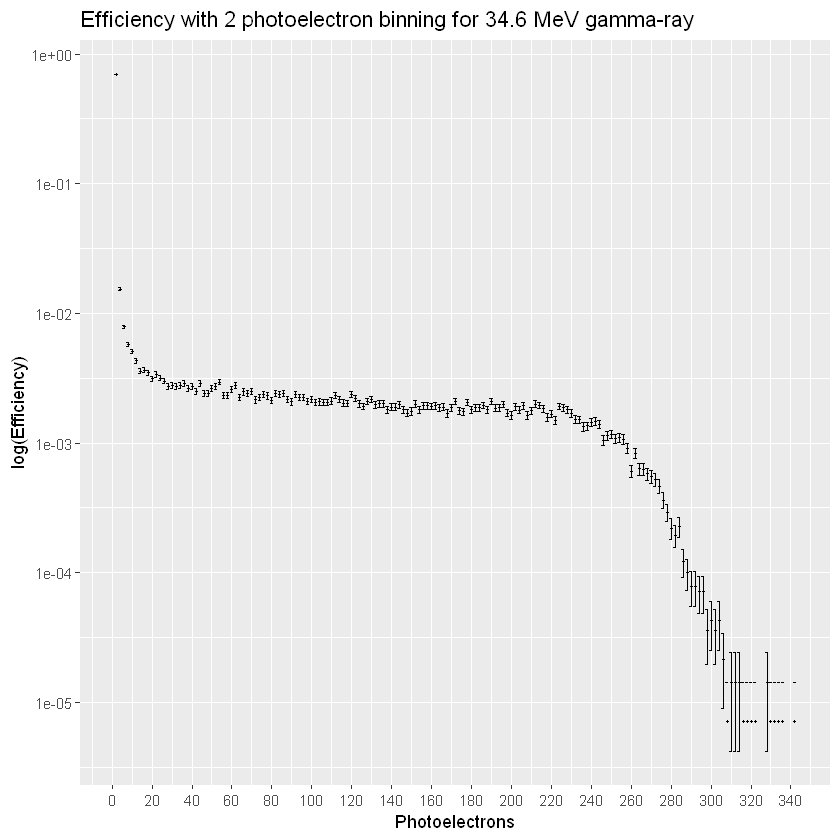

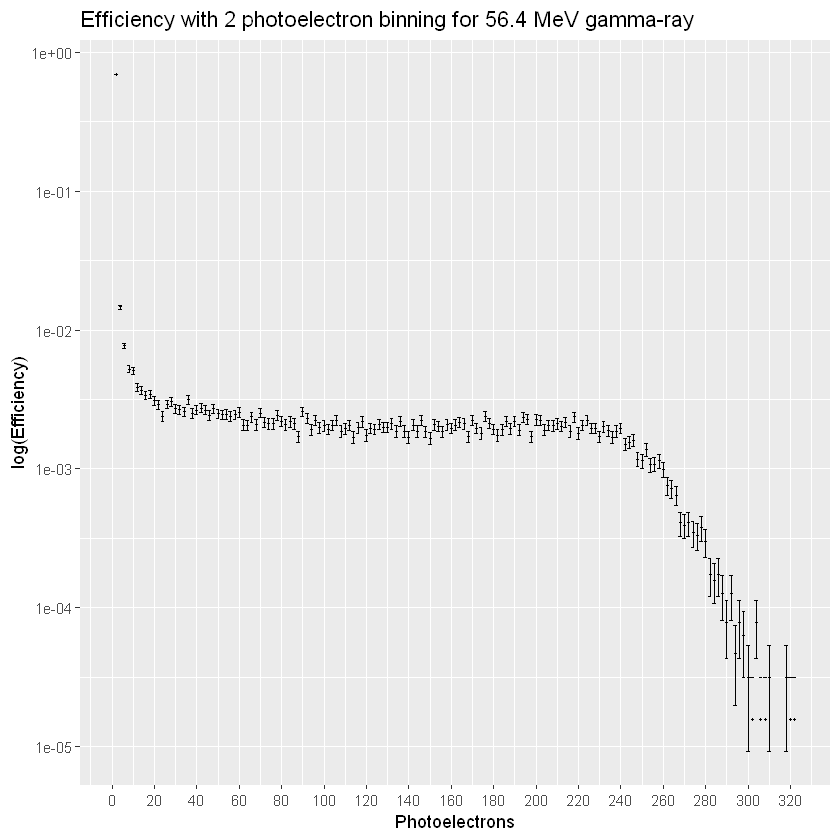

In [22]:
# Print the efficiency plots
# To print plots for all the energy level loop through eng_ls_all
# To print plots for a selected energy level loop through eng_ls_sel

eng_ls_all<-1:23
eng_ls_sel<-c(1,5,10,15,23)

for (i in eng_ls_sel){
    df <- subset(df_eff_all, Energy == df_run_eng[i,2])
    plt <- plt_eff(df, i)
    print(plt)
    }

# Geant4 Monte Carlo Simulation

The photon's passage through quartz detector was simulated via Geant4 toolkit with manually implemented beamtime geometry, material properties, and particle physics. Details of the simulation setup can be found in chapter 3.2. 

Number of photons in the photon beam was set to 1 million. Each sessions utilized a beam energy ranging from 15 MeV to 55 MeV. Three different cases were investigated including the ideal case and two others to measure the impact from possible human error. 

The base case replicated an ideal experiment setup with the beam entering the quartz detector in the center perpendicular to the plane. Angle and position studied modified the beam angle and the position on the plane. Detailed geometric descriptions are shown in chapter 4.2.2.

## Combining the Simulation Data

In [23]:
df_sim <- function(runid){
    
    # This function reads the simulation data
    # runind is the beam energy
    
    setwd("D:/rootout/mod_geom")
    fl <- paste("D:/rootout/mod_geom/base",runid,".cvs", sep ='')
    print(fl)
    df <- read.table(file=fl, header = FALSE)
    colnames(df) <- c("Photoelectrons", "Efficiency", "error")
    df = df %>% 
        mutate(ymin = Efficiency - error) %>%
        mutate(ymax = Efficiency + error) %>% 
        mutate(Energy = paste("Sim.", runid, "MeV", sep =''))
    
    df<-df[df$Efficiency != 0,]
    df
    }

# df_comb<- function(runid, ls){
    
#     # This function corrects the data corruption
#     # Removes 0 photoelectron counts
#     # And corrects the photoelectron numbers 
    
#     sdf <- df_sim(runid)
#     sdf <- sdf[-1,]
#     sdf$Photoelectrons <- sdf$Photoelectrons - 1
#     head(sdf)
#     ls_rng<-ls
#     for (i in ls_rng){
#         df <- cut_eff_df(i, 2, 0) 
#         df$Energy<-df_run_eng[i,2]    
#         sdf_15<-rbind(sdf, df)
#         }
#     sdf
#     }

df_sims_exp_comb<- function(runid, ls){
    
    # This function corrects the simulation data corruption 
    # Removes 0 photoelectron counts
    # And corrects the photoelectron numbers 
    # Merges the simulation data with a corresponding experiment data
    # Returns the merged dataframe
    sdf <- df_sim(runid)
    sdf <- sdf[-1,]
    sdf$Photoelectrons <- sdf$Photoelectrons - 1
    head(sdf)
    ls_rng<-ls
    for (i in ls_rng){
        df <- cut_eff_df(i, 2, 0) 
        df$Energy<-df_run_eng[i,2]    
        sdf<-rbind(sdf, df)
        }
    sdf
    
    }



In [24]:
# Here, combine the simulation data 
# with the corresponding experimental energies

df_comb_15<-df_sims_exp_comb(15, 5:7)
df_comb_20<-df_sims_exp_comb(20, c(1,2,8))
df_comb_25<-df_sims_exp_comb(25, c(3,4,9))
df_comb_30<-df_sims_exp_comb(30, 11:13)
df_comb_35<-df_sims_exp_comb(35, 13:15)
df_comb_40<-df_sims_exp_comb(40, 16:18)
df_comb_50<-df_sims_exp_comb(50, 19:21)


[1] "D:/rootout/mod_geom/base15.cvs"


Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


[1] "D:/rootout/mod_geom/base20.cvs"


Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


[1] "D:/rootout/mod_geom/base25.cvs"


Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


[1] "D:/rootout/mod_geom/base30.cvs"


Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


[1] "D:/rootout/mod_geom/base35.cvs"


Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


[1] "D:/rootout/mod_geom/base40.cvs"


Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


[1] "D:/rootout/mod_geom/base50.cvs"


Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"


## Base Case Analysis

In [25]:
plt_df <-function(df, eng){
    p <- ggplot(df , aes(x = Photoelectrons, y = Efficiency, color = factor(Energy))) + 
         geom_errorbar(aes(ymin = ymin, ymax = ymax)) +
         theme_grey() +
         scale_y_continuous(trans = 'log',breaks = scales::trans_breaks("log10", function(x) 10^x)) +
         ggtitle(paste("Efficiency with 2 photoelectron binning ", eng, " MeV", sep="")) +
         labs(colour = "Energy(MeV)") +
         ylab("log(Efficiency)")
    p
        }

The experimental plots show minimal differences in characteristics. Distinct differences can be seen between the experiment and simulation data. Notably, the long extending shoulders are absent in the simulation plots. A subsequent experiments with lower beam rate resulted in the experimental plots more in congruence with the simulation data. 

The highest peak in the simulation plot, which represents the coresponding photon's probability to interact with quartz, shows close proximity in order of 10^-2.

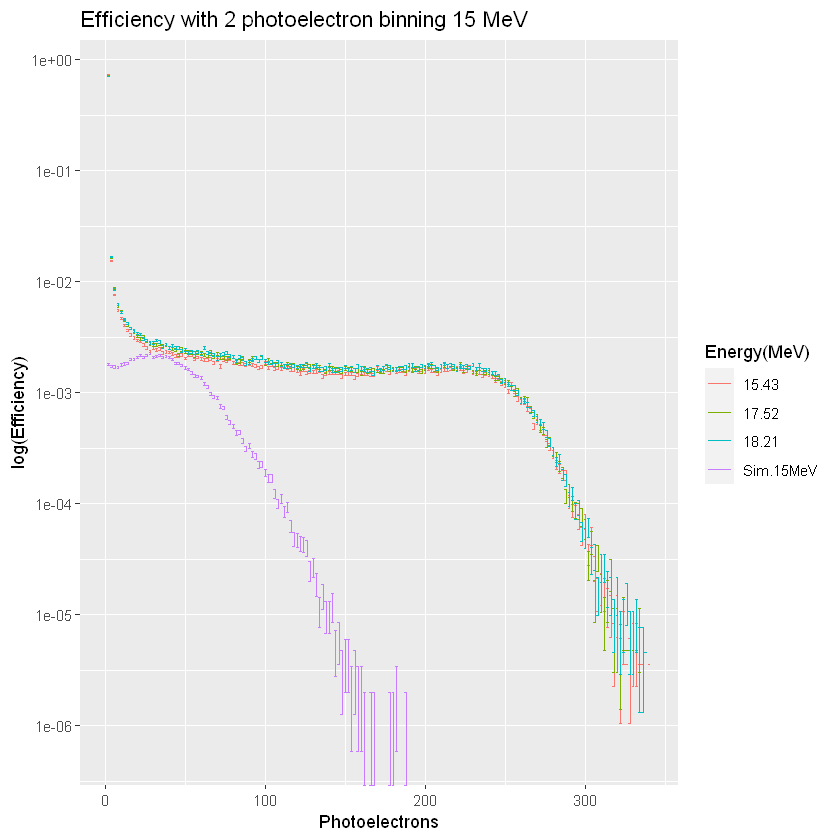

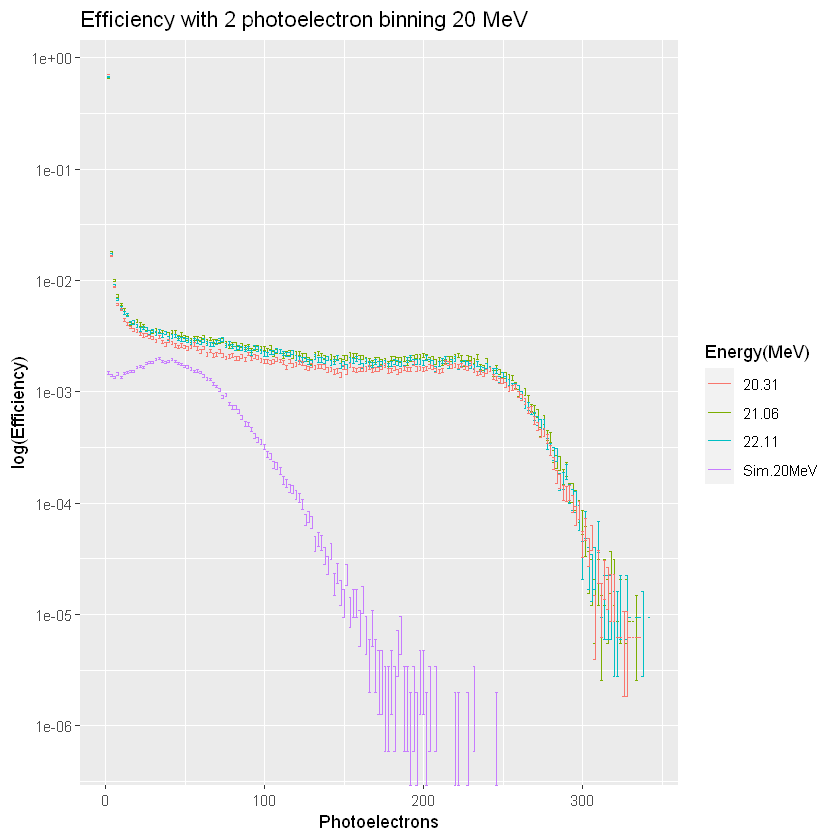

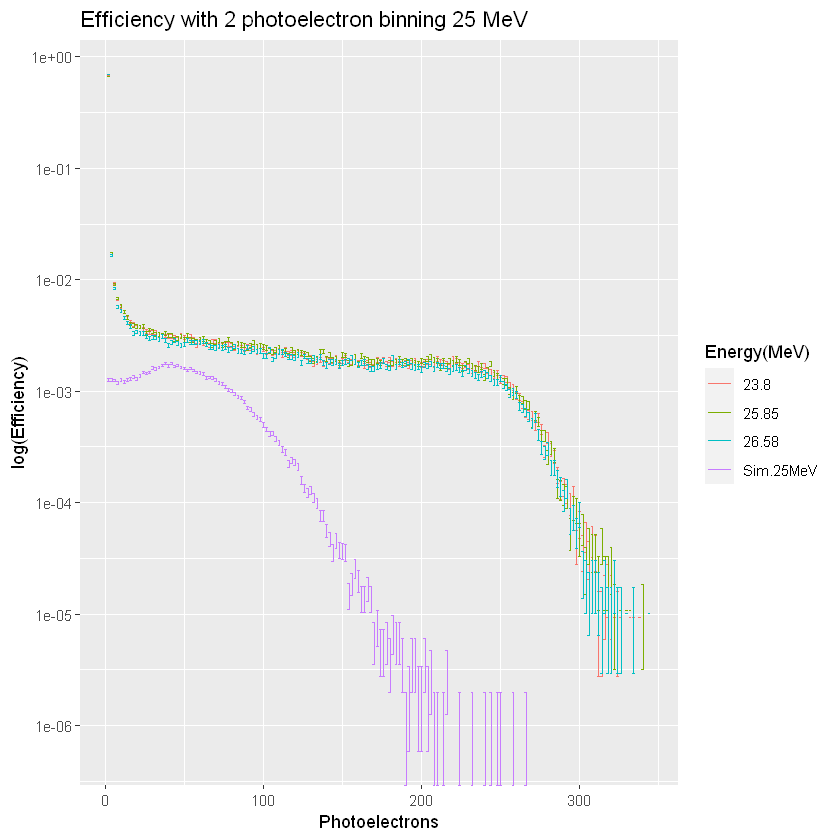

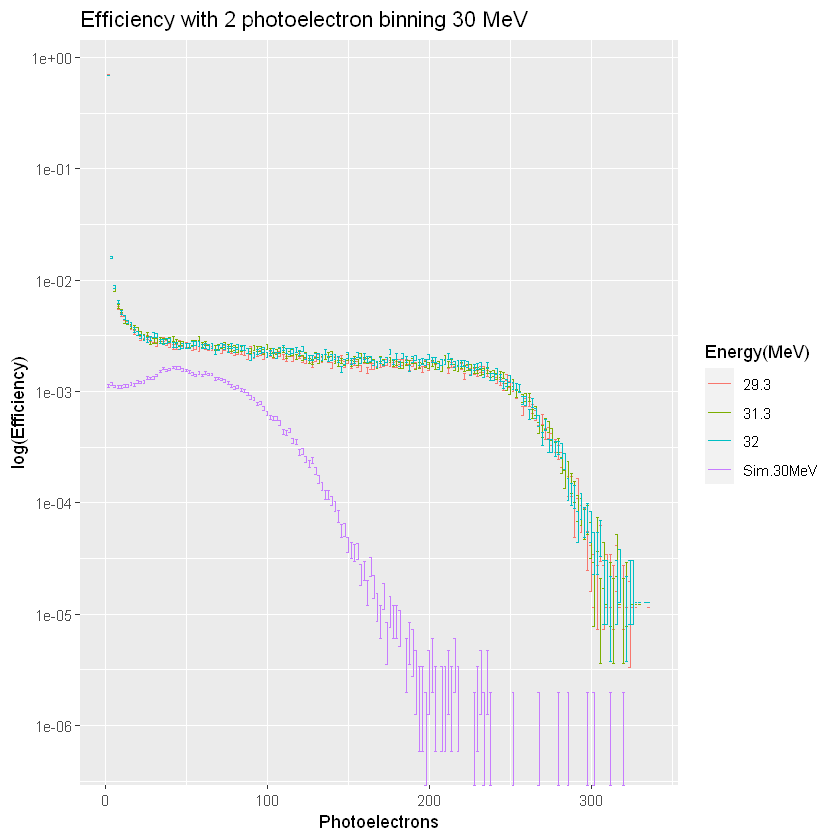

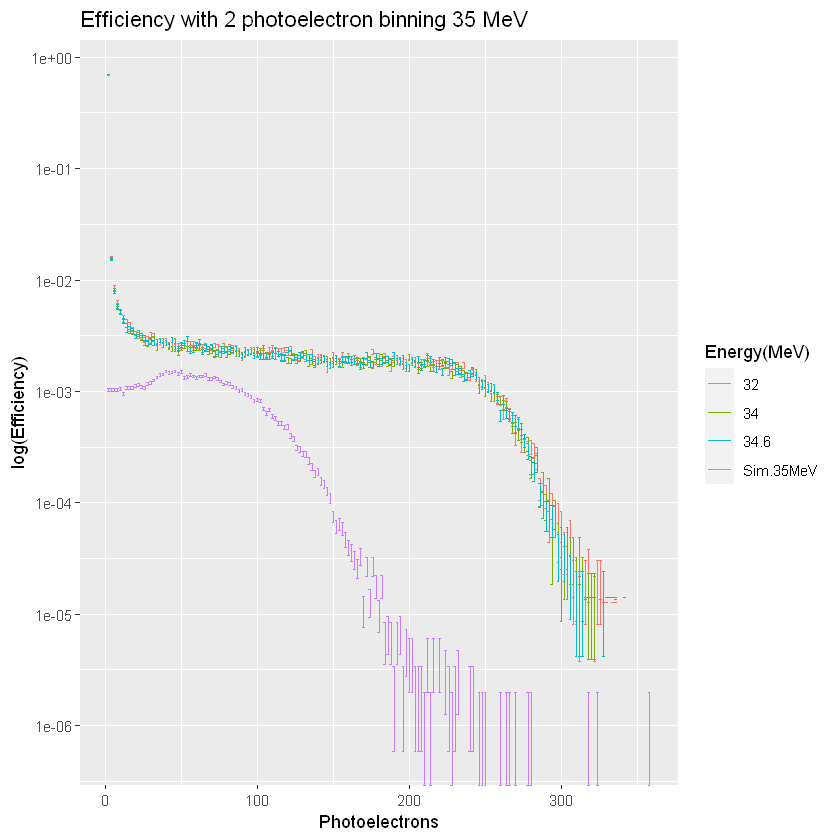

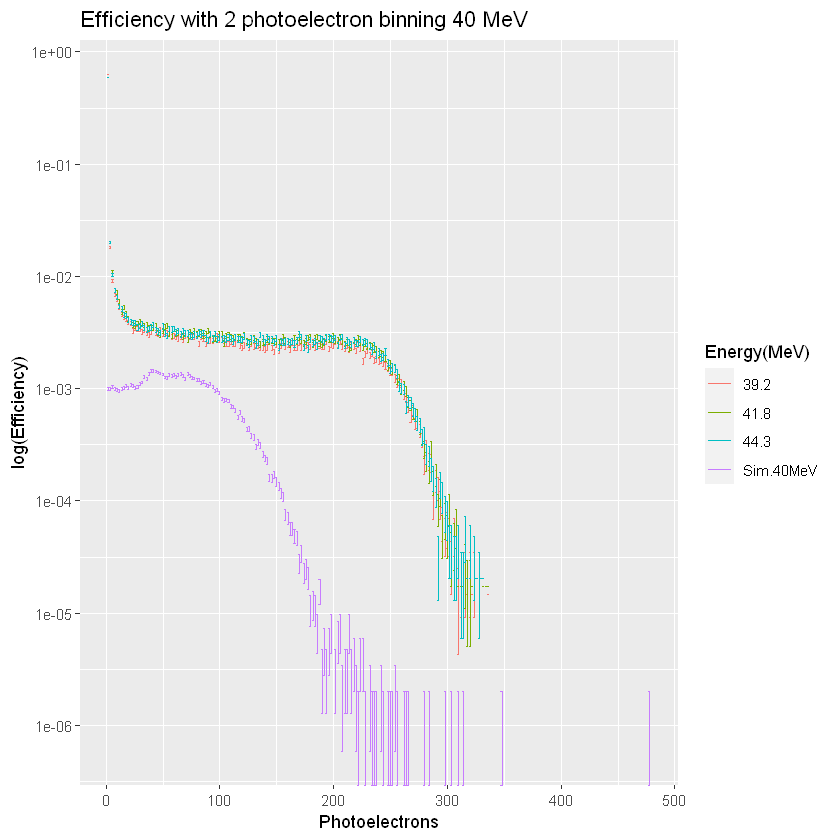

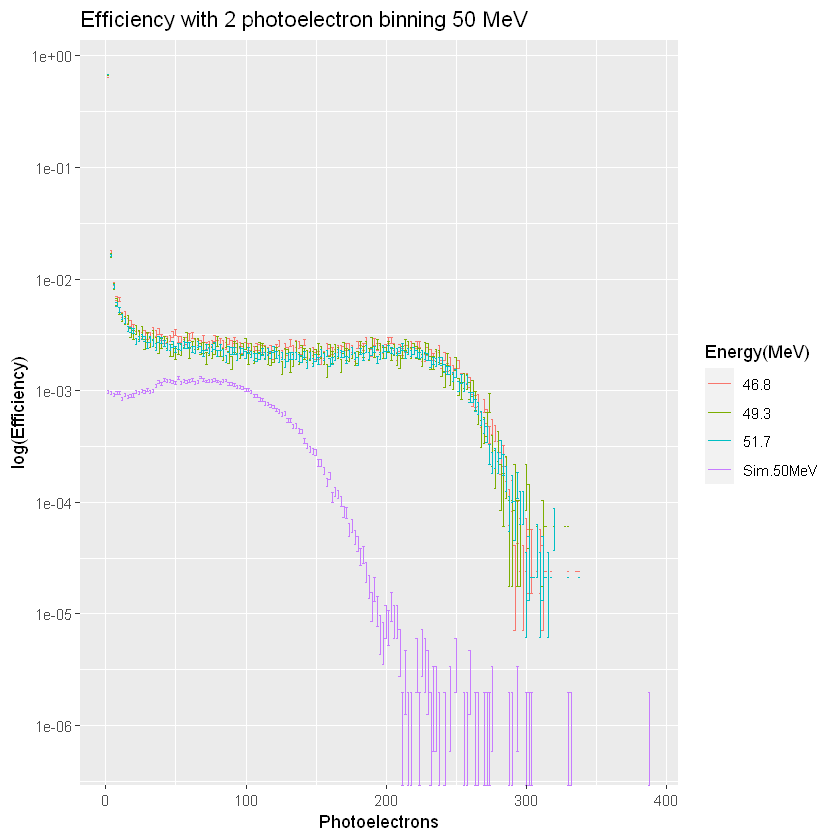

In [26]:
plt_df(df_comb_15, "15")
plt_df(df_comb_20, "20")
plt_df(df_comb_25, "25")
plt_df(df_comb_30, "30")
plt_df(df_comb_35, "35")
plt_df(df_comb_40, "40")
plt_df(df_comb_50, "50")

## Simulation and Experimental Plots

In [27]:
comb_sim<- function(){
    
    # This function combines all the simulation data
    
    ls <-c(20, 25, 30, 35, 40, 50)

    sdf <- df_sim(15)
    sdf <- sdf[-1,]
    sdf$Photoelectrons <- sdf$Photoelectrons - 1
    ls_rng<-ls
    for (i in ls){
        df_tmp <- df_sim(i)
        df_tmp$Photoelectrons <- df_tmp$Photoelectrons - 1
        df_tmp <- df_tmp[-1,]
        sdf<-rbind(sdf, df_tmp)
        }
    sdf
    }                            
                                                                        
comb_exp<- function(j, ls){
    
    # This function combines selected experimental data
    
    edf <-cut_eff_df(j, 2, 0) %>% mutate(Energy = df_run_eng[j,2])
    ls_rng<-ls
    for (i in ls_rng){
        df_tmp <- cut_eff_df(i, 2, 0) %>% mutate(Energy = df_run_eng[i,2])
        head(df_tmp)
        df_tmp$Energy<-df_run_eng[i,2]    
        edf<-rbind(edf, df_tmp)
        }
    edf
    }        
           

In [28]:
df_comb_sim <- comb_sim()

df_comb_exp <- comb_exp(5, c(9, 14, 19, 22))
df_comb_exp_all <- comb_exp(1, 2:23)

[1] "D:/rootout/mod_geom/base15.cvs"
[1] "D:/rootout/mod_geom/base20.cvs"
[1] "D:/rootout/mod_geom/base25.cvs"
[1] "D:/rootout/mod_geom/base30.cvs"
[1] "D:/rootout/mod_geom/base35.cvs"
[1] "D:/rootout/mod_geom/base40.cvs"
[1] "D:/rootout/mod_geom/base50.cvs"


Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, by = "event"
Joining, b

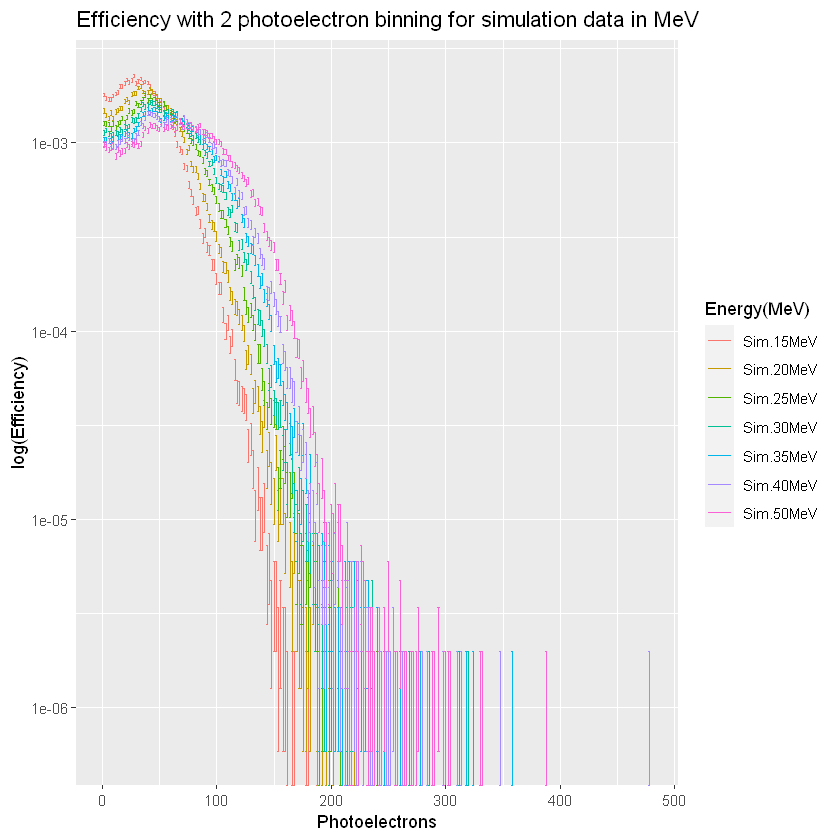

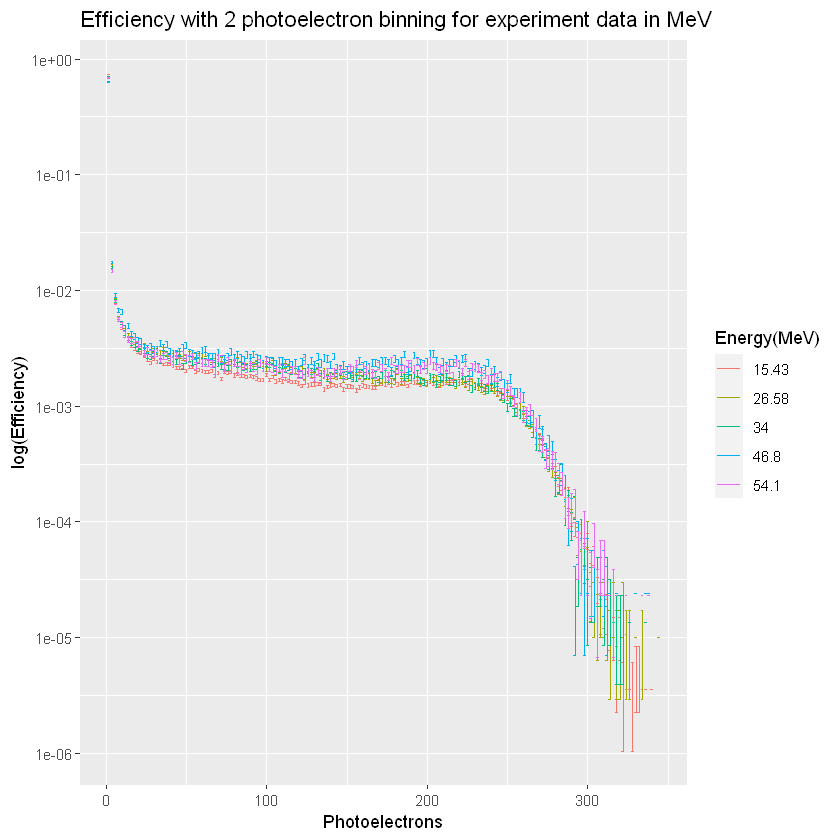

In [29]:
plt_df(df_comb_sim, "for simulation data in")
plt_df(df_comb_exp, "for experiment data in")

## Angle Error Analysis

It is possible that the quartz detector was misreplaced in a tilted position in the experiment setup. This project assumes that the maximum tilted angle in both forward and back direction to be undetected by the human subject is 6 degrees. Therefore, the beam entered center of the quartz detector +- 6 degrees tilted in respect to the simulated geometry. The geometrical description can be found in figure 4.10 on page 66.

In [30]:
read_ang_sim <- function(ang){
    
    # This function reads positive and negative angle data files
    # apply the estimated error from the previous calculation
    # Returns a dataframe for the angle studies
    
    if (ang == "pos"){
        degree = "posang"
        ang_tl <- "+6 degrees"
        }
    if (ang == "neg"){
        degree = "negang"
        ang_tl <- "-6 degrees"
    }

    setwd("D:/rootout/anglestudy")
    fl <- paste("D:/rootout/anglestudy/",degree,".cvs", sep ='')
    print(fl)
    adf <- read.table(file=fl, header = FALSE)
    colnames(adf) <- c("Photoelectrons", "Efficiency", "error")
    
    adf <- adf %>% 
            mutate(ymin = Efficiency - error) %>% 
            mutate(ymax = Efficiency + error) %>% 
            mutate(Energy = paste(ang_tl,"MeV")
                      )
    adf<-adf[adf$Efficiency != 0,]
    
    adf
    
    }


[1] "D:/rootout/anglestudy/posang.cvs"
[1] "D:/rootout/anglestudy/negang.cvs"
[1] "D:/rootout/mod_geom/base35.cvs"


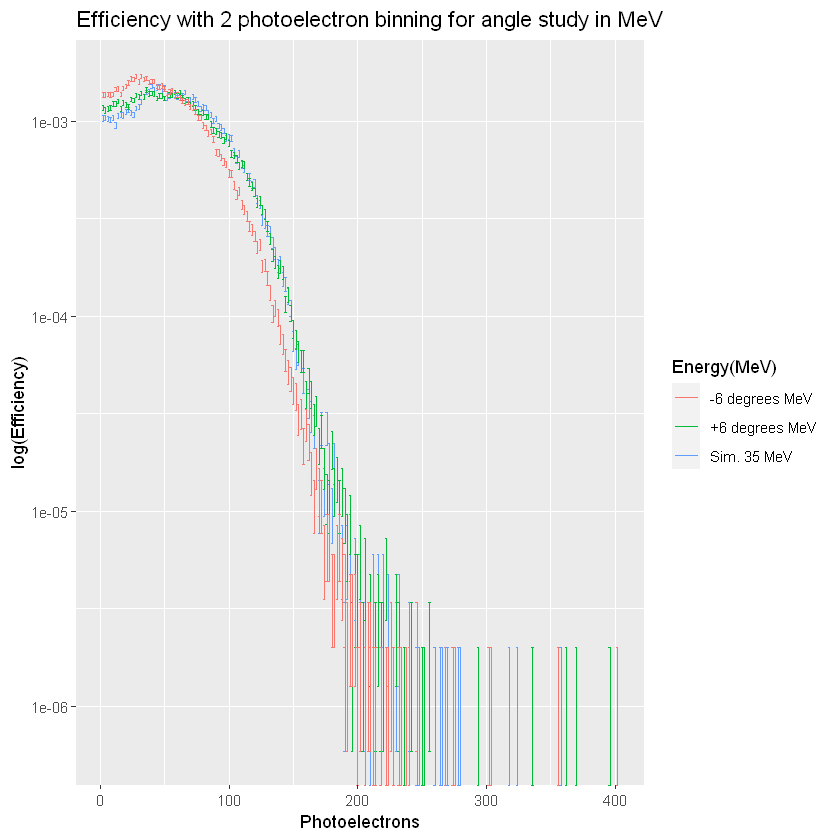

In [31]:
# Read angle datas and correct data corruptions

df_pos<-read_ang_sim("pos")
df_neg<-read_ang_sim("neg")

df_pos$Photoelectrons <- df_pos$Photoelectrons - 1
df_neg$Photoelectrons <- df_neg$Photoelectrons - 1

df_pos <- df_pos[-1,]
df_neg <- df_neg[-1,]

# Read base case for the corresponding energy 35 MeV
# Merge the base case and the angle data 

edf_35 <- df_sim(35)
edf_35$Photoelectrons <- edf_35$Photoelectrons - 1
edf_35$Energy <- "Sim. 35 MeV"
edf_35 <- edf_35[-1,]
df_ang <- rbind(edf_35, df_pos, df_neg)
df_ang$Energy <- df_ang$Energy %>% as.factor() 
# Plot the angle study plots

p<-plt_df(df_ang,"for angle study in")

p

There are only minimum differences in distributions among the plots in above graph. It is easily conclude that there are only negligible statistical differences arising from angle error. Statistical summary for each plots are listed below.

In [32]:
"- 6 degrees"%>%print()
subset(df_ang, Energy == '-6 degrees MeV')$Efficiency%>% summary()
"+ 6 degrees"%>%print()
subset(df_ang, Energy == '+6 degrees MeV')$Efficiency%>% summary()
"Base case"%>%print()
subset(df_ang, Energy == "Sim. 35 MeV")$Efficiency%>% summary()

[1] "- 6 degrees"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000010 0.0000045 0.0002260 0.0005678 0.0012990 0.0017080 

[1] "+ 6 degrees"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.000e-06 6.250e-06 2.690e-04 5.377e-04 1.174e-03 1.454e-03 

[1] "Base case"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.000e-06 5.750e-06 2.875e-04 5.465e-04 1.088e-03 1.510e-03 

## Position Study

The position of the beam entering the quartz detector could impact the efficiency, as it changes the resulting optical photons path to the PMT. Since the exact location of the photon beam striking the detector is unknown outputs from 9 different beam positions are compared. The beam was centered on each of the nine equally divided sections, as seen in figure 4.12.

In [33]:
pos_base_fn <- function(){
    
    # This function creates base case df 
    # for the position analysis
    
    setwd("D:/rootout")
    fl <- "D:/rootout/30_sim_new.cvs"
    print(fl)
    df <- read.table(file=fl, header = FALSE)
    colnames(df) <- c("Photoelectrons", "Efficiency", "error")
    df = df %>% 
        mutate(ymin = Efficiency - error) %>% 
        mutate(ymax = Efficiency + error) %>% 
        mutate(Energy = paste("Position 5"))
    df<-df[df$Efficiency != 0,]
    return (df)
    }

pos_base <- pos_base_fn()
pos_base <- pos_base[-1,]
pos_base$Photoelectrons <- pos_base$Photoelectrons - 1
head(pos_base)

[1] "D:/rootout/30_sim_new.cvs"


,Photoelectrons,Efficiency,error,ymin,ymax,Energy
2,2,0.00113001,3.36155e-05,0.001096395,0.001163626,Position 5
3,4,0.00116501,3.41321e-05,0.001130878,0.001199142,Position 5
4,6,0.00111001,3.33167e-05,0.001076693,0.001143327,Position 5
5,8,0.00109001,3.30151e-05,0.001056995,0.001123025,Position 5
6,10,0.00110301,3.32114e-05,0.001069799,0.001136221,Position 5
7,12,0.00112401,3.35261e-05,0.001090484,0.001157536,Position 5


In [34]:
read_pos <- function(pos){
    
    setwd("D:/rootout/pos_study")
    fl <- paste("D:/rootout/pos_study/post",pos,".cvs", sep ='')
    print(fl)
    df <- read.table(file=fl, header = FALSE)
    colnames(df) <- c("Photoelectrons", "Efficiency", "error")
    df = df %>% 
            mutate(ymin = Efficiency - error) %>% 
            mutate(ymax = Efficiency + error) %>% 
            mutate(Energy = paste("Position", pos))
    df<-df[df$Efficiency != 0,]

    df
    }

comb_pos_fn<-function(){
    df<-read_pos(1)
    df$Photoelectrons <- df$Photoelectrons - 1
    df<-df[-1,]
    df$Energy<-"Position 1"
    
    for(i in 2:9){
        if(i != 5)
            {
             df_tmp<-read_pos(i)
            
        }
        else
            {
            df_tmp<-pos_base_fn()
        }
        df_tmp$Photoelectrons <- df_tmp$Photoelectrons - 1
        df_tmp<-df_tmp[-1,]
        df<-rbind(df, df_tmp)
    }
    colnames(df)[which(names(df) == "Energy")] <- "Position"
    df$Position <- factor(df$Position)
    df
}

df_position<-comb_pos_fn()
head(df_position)
tail(df_position)

print(df_position$Position)



[1] "D:/rootout/pos_study/post1.cvs"
[1] "D:/rootout/pos_study/post2.cvs"
[1] "D:/rootout/pos_study/post3.cvs"
[1] "D:/rootout/pos_study/post4.cvs"
[1] "D:/rootout/30_sim_new.cvs"
[1] "D:/rootout/pos_study/post6.cvs"
[1] "D:/rootout/pos_study/post7.cvs"
[1] "D:/rootout/pos_study/post8.cvs"
[1] "D:/rootout/pos_study/post9.cvs"


,Photoelectrons,Efficiency,error,ymin,ymax,Position
2,2,0.001087,3.29697e-05,0.001054030,0.001119970,Position 1
3,4,0.001055,3.24808e-05,0.001022519,0.001087481,Position 1
4,6,0.001071,3.27261e-05,0.001038274,0.001103726,Position 1
5,8,0.001041,3.22645e-05,0.001008736,0.001073264,Position 1
6,10,0.001113,3.33617e-05,0.001079638,0.001146362,Position 1
7,12,0.001052,3.24345e-05,0.001019566,0.001084434,Position 1


,Photoelectrons,Efficiency,error,ymin,ymax,Position
1323,262,1e-06,1e-06,0,2e-06,Position 9
1333,264,1e-06,1e-06,0,2e-06,Position 9
1371,272,1e-06,1e-06,0,2e-06,Position 9
1432,284,1e-06,1e-06,0,2e-06,Position 9
1501,298,1e-06,1e-06,0,2e-06,Position 9
1591,316,1e-06,1e-06,0,2e-06,Position 9


   [1] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
   [7] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [13] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [19] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [25] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [31] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [37] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [43] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [49] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [55] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [61] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [67] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [73] Position 1 Position 1 Position 1 Position 1 Position 1 Position 1
  [79] Position 1 Position 1 Position 1 Position 1 

In [35]:
plt_pos_df <-function(df){
    
    # This function creates a graph containing all the position plots

    p <- ggplot(df , aes(x = Photoelectrons, y = Efficiency, color = factor(Position))) + 
         geom_errorbar(aes(ymin = ymin, ymax = ymax)) +
         theme_grey() +
         scale_y_continuous(trans = 'log',breaks = scales::trans_breaks("log10", function(x) 10^x)) +
         ggtitle(paste("Position Study: efficiency with 2 photoelectron 35 MeV", sep=""),
                "For all positions") +
         labs(colour = "Energy(MeV)") +
         ylab("log(Efficiency)")
    p
        }

                                                                                
                                                                        
plt_pos_sub_df <-function(df, pos_1, pos_2, pos_3){
    
    # This function creates a graph containing selected position plots
    # input parameters pos_1, pos_2, pos_3 are the positions of interst
    
    df_sub <- subset(df, Position %in% c(pos_1, pos_2, pos_3))
    p <- ggplot(df_sub, aes(x = Photoelectrons, y = Efficiency, color = factor(Position))) + 
         geom_errorbar(aes(ymin = ymin, ymax = ymax)) +
         theme_grey() +
         scale_y_continuous(trans = 'log',breaks = scales::trans_breaks("log10", function(x) 10^x)) +
         ggtitle("Position Study: efficiency with 2 photoelectron binning 35 MeV", 
                paste("For positions: ", pos_1, ",", pos_2, ",", pos_3, sep=" ")) +
         labs(colour = "Energy(MeV)") +
         ylab("log(Efficiency)")
    p
        }

The below graphs show efficiency plots from the various positions. No significant difference are seen from the plots and the statistics listed below.

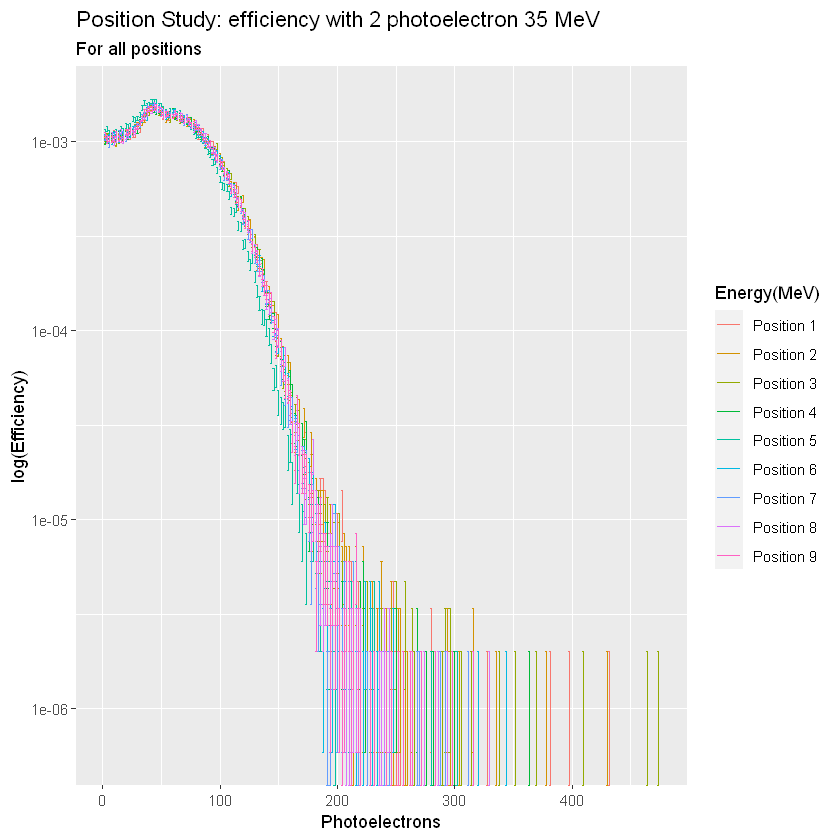

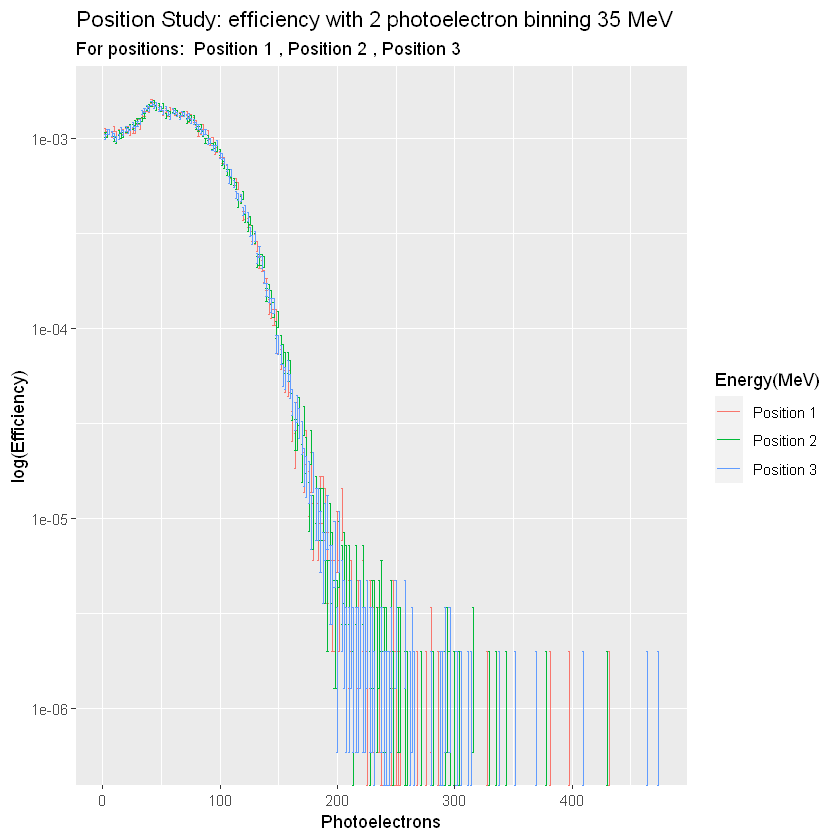

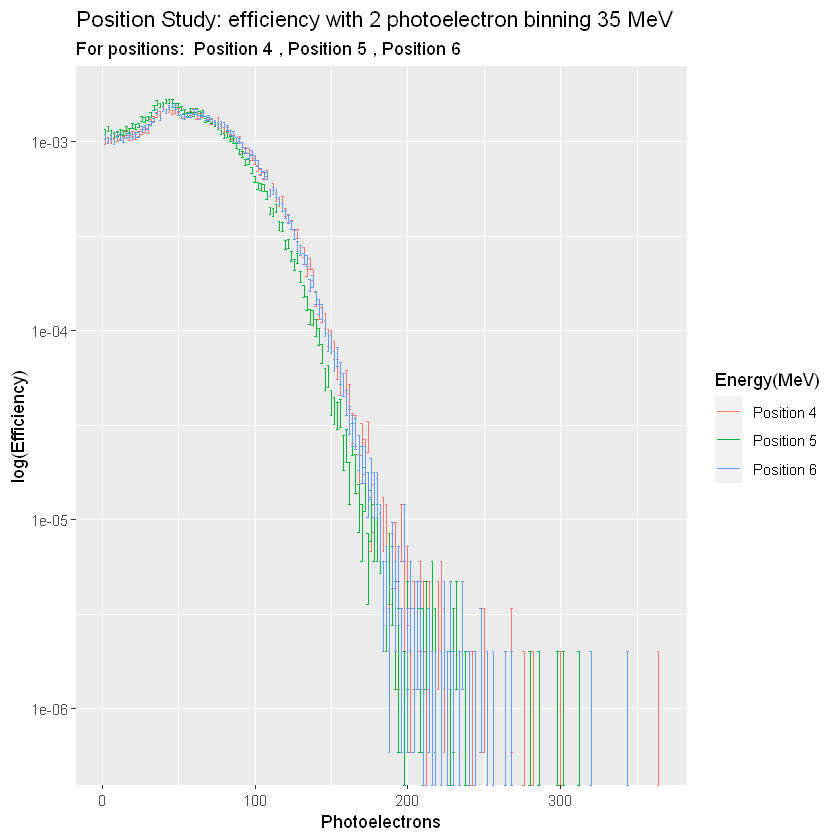

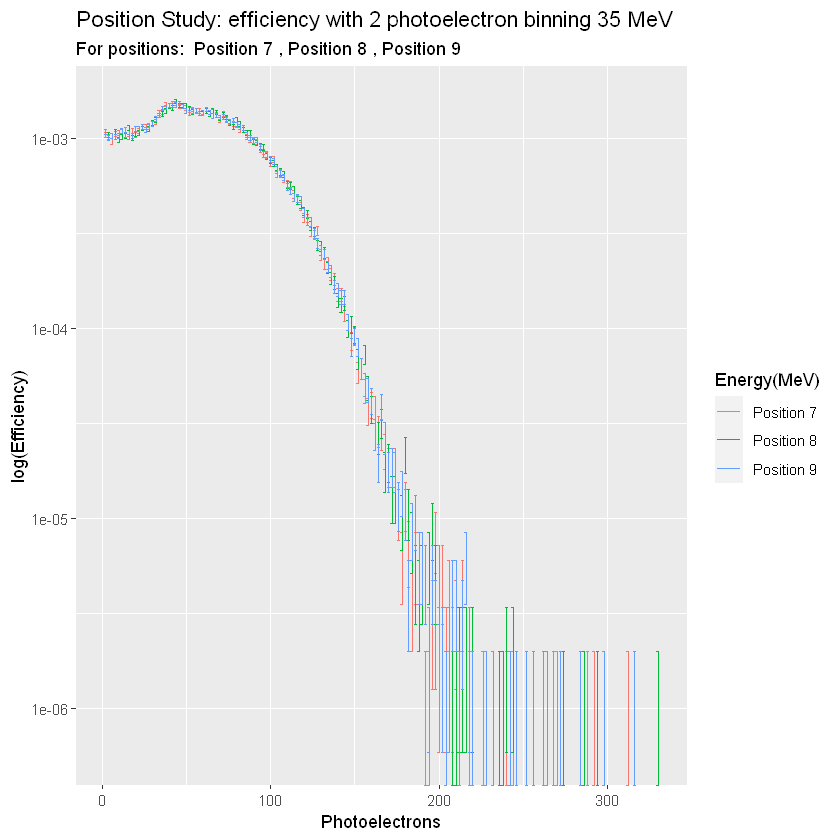

In [36]:
plt_pos_df(df_position)

plt_pos_sub_df(df_position, "Position 1", "Position 2", "Position 3")
plt_pos_sub_df(df_position, "Position 4", "Position 5", "Position 6")
plt_pos_sub_df(df_position, "Position 7", "Position 8", "Position 9")

In [47]:
print("Stastical Summaries")
print("Position 1")
subset(df_position, Position == 'Position 1')$Efficiency %>% summary()
print("Position 2")
subset(df_position, Position == 'Position 2')$Efficiency %>% summary()
print("Position 3")
subset(df_position, Position == 'Position 3')$Efficiency %>% summary()
print("Position 4")
subset(df_position, Position == 'Position 4')$Efficiency %>% summary()
print("Position 5")
subset(df_position, Position == 'Position 5')$Efficiency %>% summary()
print("Position 6")
subset(df_position, Position == 'Position 6')$Efficiency %>% summary()
print("Position 7")
subset(df_position, Position == 'Position 7')$Efficiency %>% summary()
print("Position 8")
subset(df_position, Position == 'Position 8')$Efficiency %>% summary()
print("Position 9")
subset(df_position, Position == 'Position 9')$Efficiency %>% summary()

[1] "Stastical Summaries"
[1] "Position 1"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000010 0.0000045 0.0002130 0.0005194 0.0010830 0.0015570 

[1] "Position 2"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000010 0.0000030 0.0001450 0.0004895 0.0010545 0.0015410 

[1] "Position 3"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000010 0.0000030 0.0001480 0.0004961 0.0010720 0.0015250 

[1] "Position 4"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000010 0.0000100 0.0003920 0.0005746 0.0011030 0.0014810 

[1] "Position 5"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000001 0.000006 0.000285 0.000572 0.001165 0.001636 

[1] "Position 6"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000010 0.0000065 0.0003430 0.0005633 0.0010955 0.0015610 

[1] "Position 7"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000010 0.0000070 0.0003800 0.0005749 0.0011160 0.0015310 

[1] "Position 8"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.000e-06 1.225e-05 4.325e-04 5.911e-04 1.121e-03 1.571e-03 

[1] "Position 9"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.000e-06 9.250e-06 3.670e-04 5.703e-04 1.123e-03 1.533e-03 

# Efficiecy of each n photoelectrons through out energies

The efficiency of each n photoelectrons are compared across the energies.

In [38]:
pl_prt_nPE <- function(df, runid, stat){
t <- df %>% filter(Photoelectrons == runid)
    head(t)
    if(stat == "sim")
        {p <- ggplot(t, aes(x = Energy, y = Efficiency)) + 
        geom_point(size = 0.5) + 
        geom_errorbar(aes(ymin = ymin, ymax = ymax)) +
#         stat_smooth(method = "loess", formula = y ~ x) +
#         geom_smooth(method = "lm", formula = y ~poly(x,2)) +
        theme_grey() +
        labs(title = paste("Simulation: ", runid, " Photoelectrons Energy vs Efficiency", sep = ""), x = "Energy (MeV)")
        return(p)
         }
    if(stat == "exp")
        {
        p <- ggplot(t, aes(x = Energy, y = Efficiency)) + 
        geom_point(size = 0.5) + 
        geom_errorbar(aes(ymin = ymin, ymax = ymax)) +
#         stat_smooth(method = "loess", formula = y ~ x) +
#         geom_smooth(method = "lm", formula = y ~poly(x,2)) +
        theme_grey() +
        labs(title = paste("Experiment: ", runid, " Photoelectrons Energy vs Efficiency", sep = ""), x = "Energy (MeV)")
        return(p)
         }
    }




## Simulation

Distinct logarithmic plots are shown from the simulation plots. The efficiencies drop up to 20PE, and increases from 50 PE.

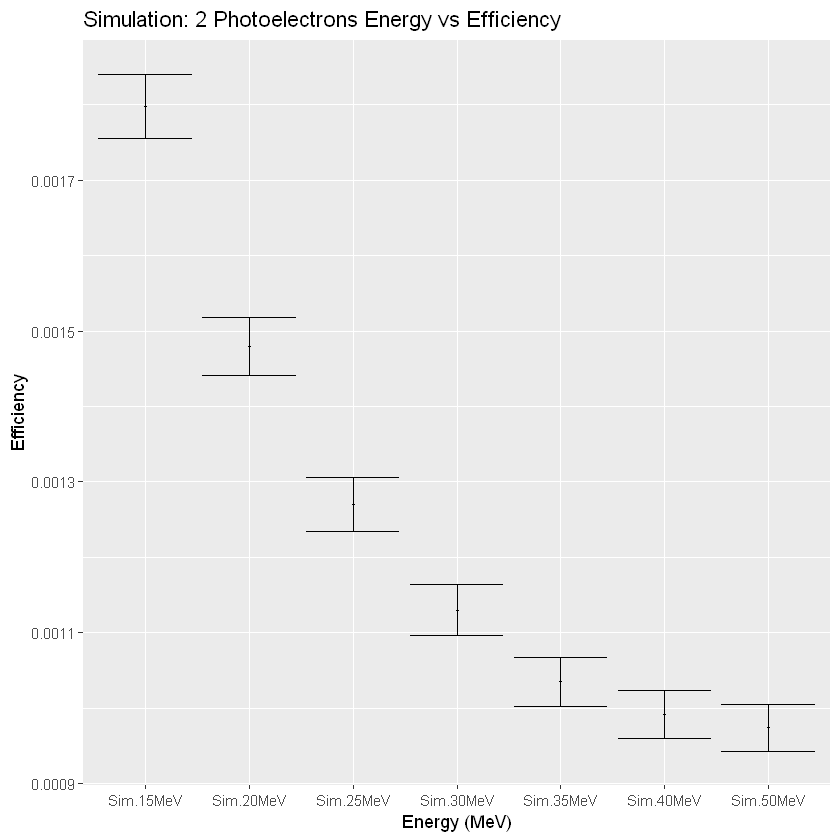

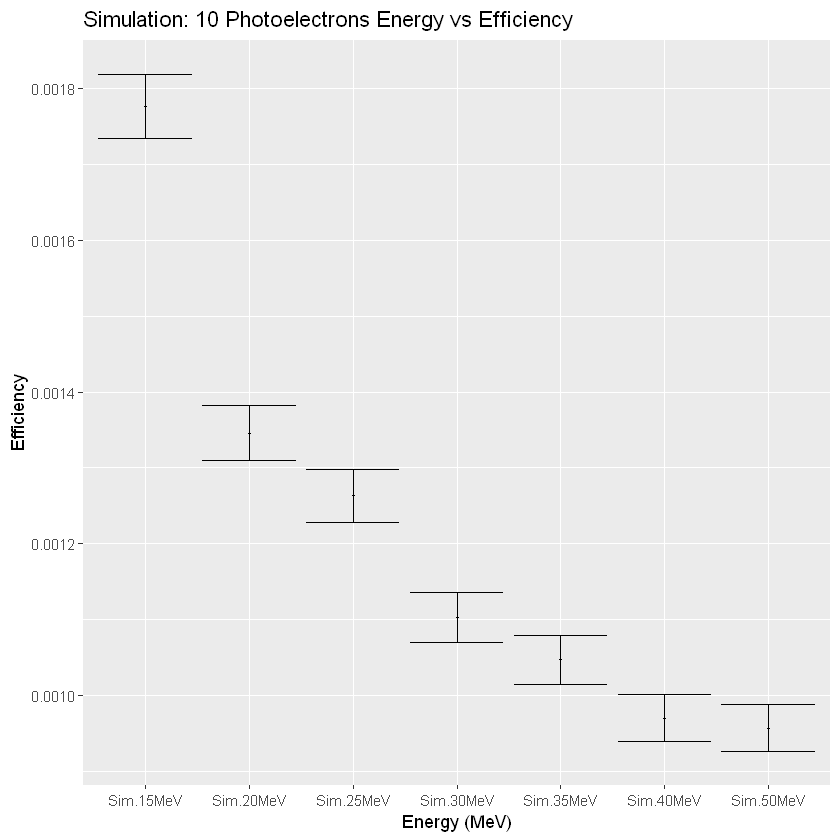

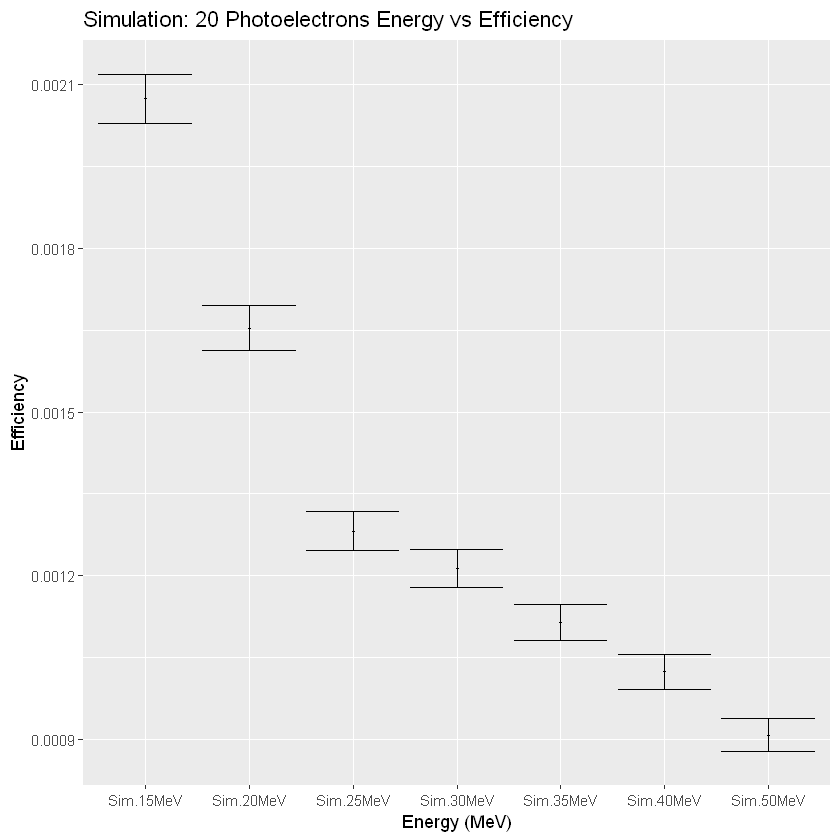

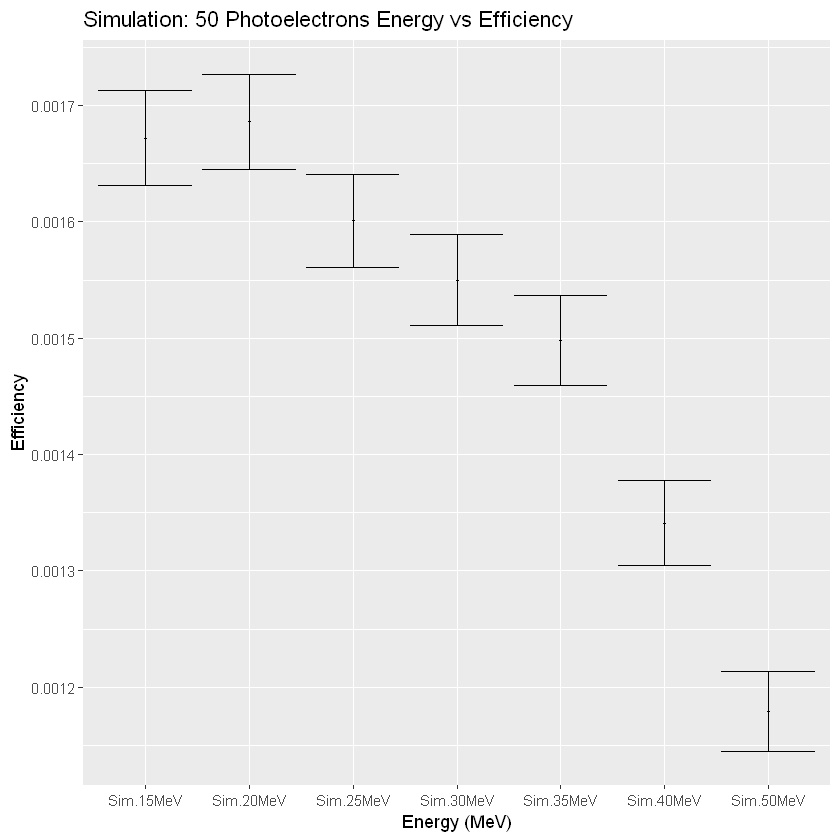

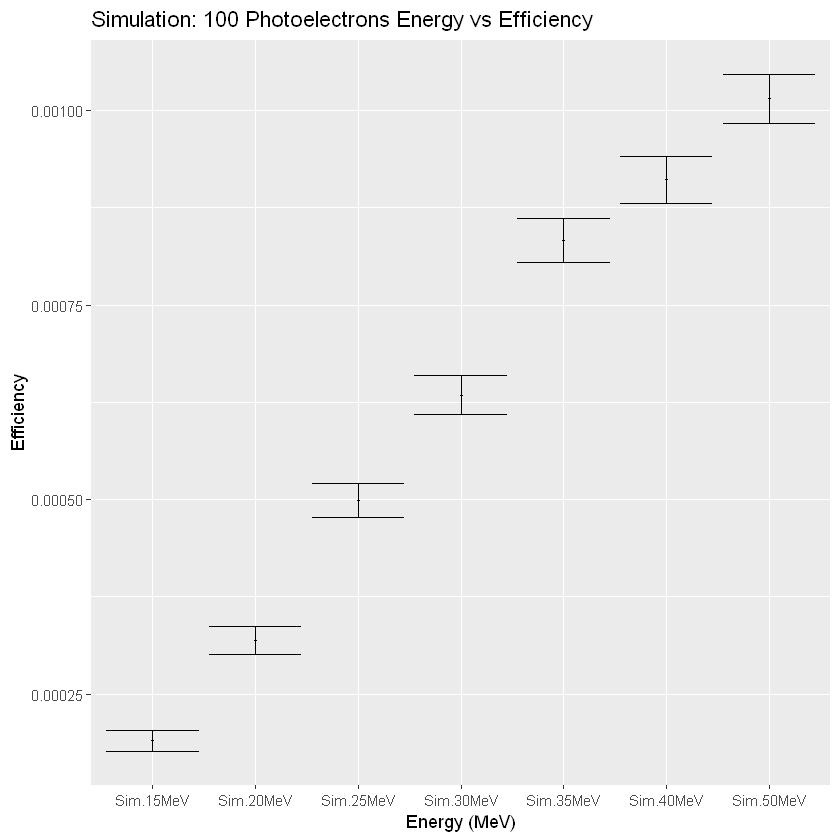

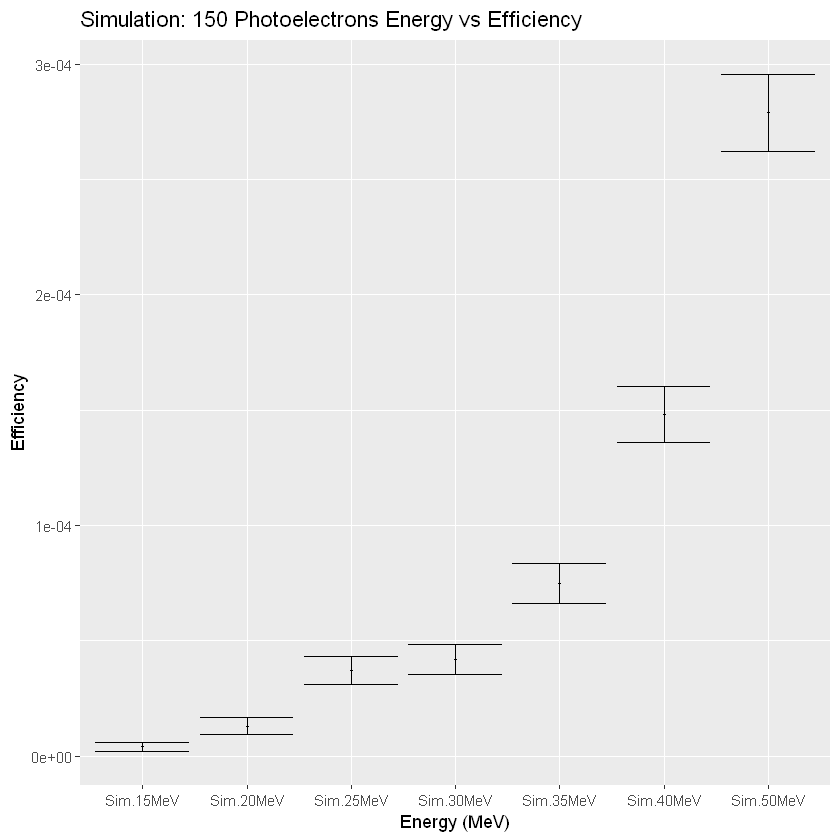

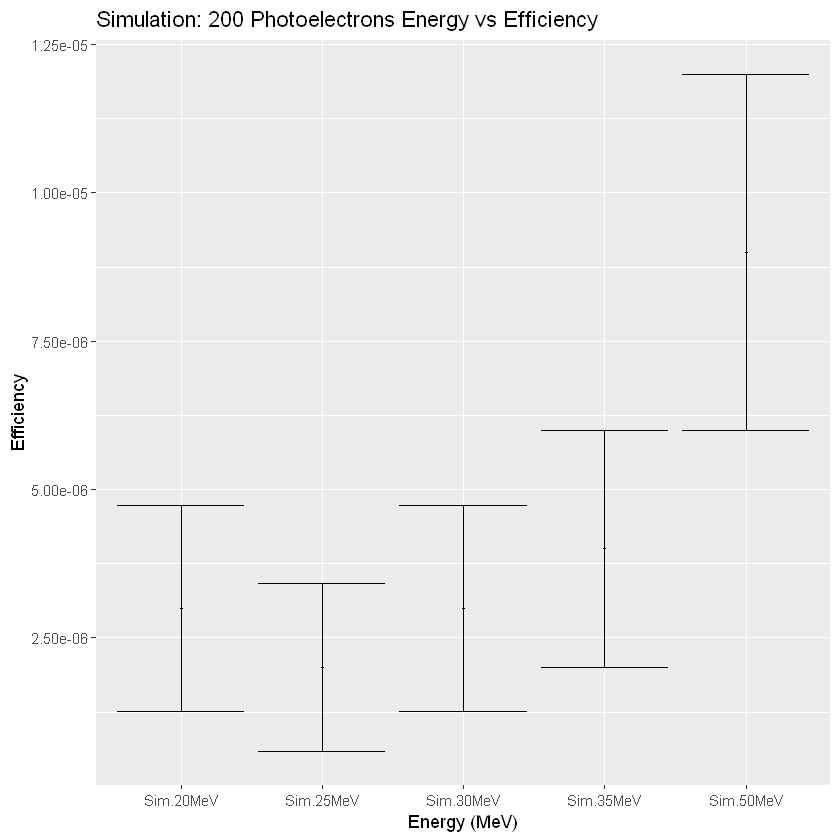

In [39]:
pl_prt_nPE(df_comb_sim, 2, "sim")
pl_prt_nPE(df_comb_sim, 10, "sim")
pl_prt_nPE(df_comb_sim, 20, "sim")
pl_prt_nPE(df_comb_sim, 50, "sim")
pl_prt_nPE(df_comb_sim, 100, "sim")
pl_prt_nPE(df_comb_sim, 150, "sim")
pl_prt_nPE(df_comb_sim, 200, "sim")

## Experiment

Unlike the above simulation plots the experiment graphs below dose not show distinctive patterns. Therefore, it is likely that the experimental data are corrupted due to the enviornmental noises.  

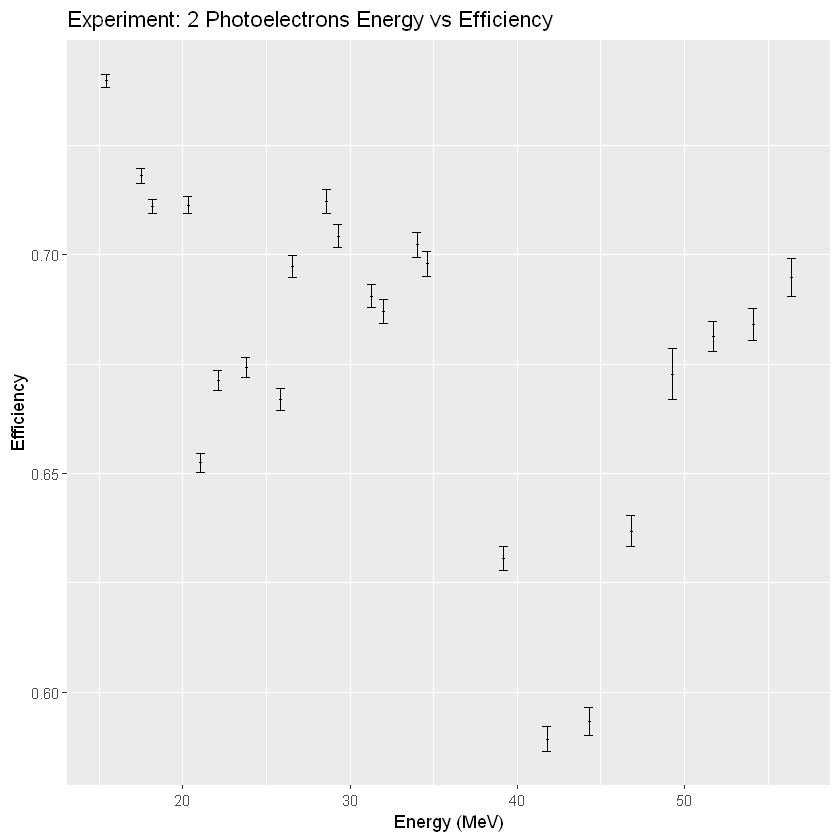

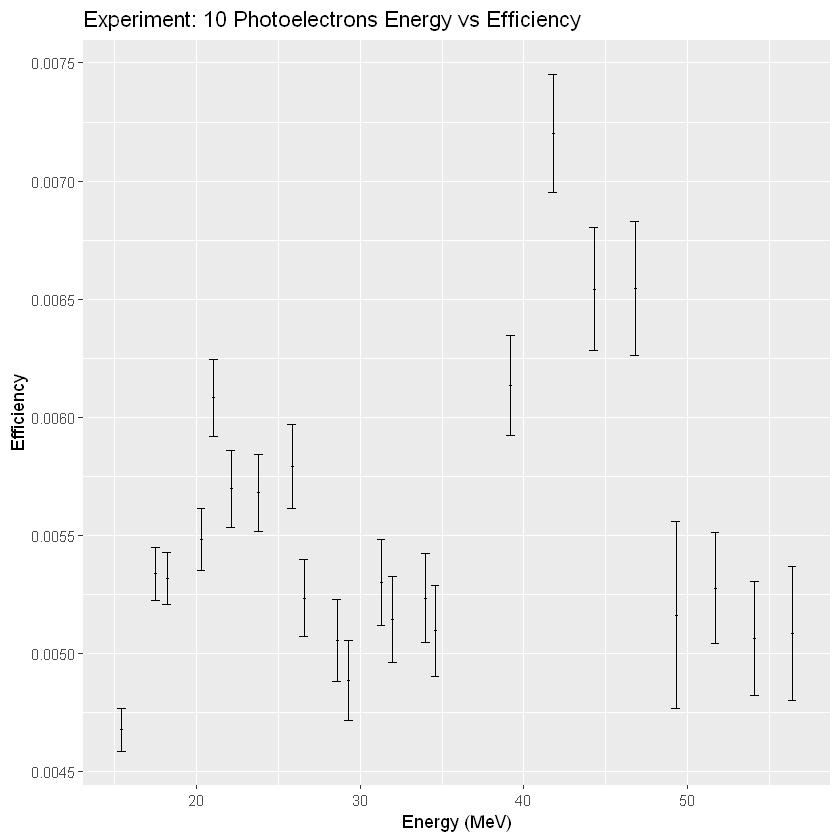

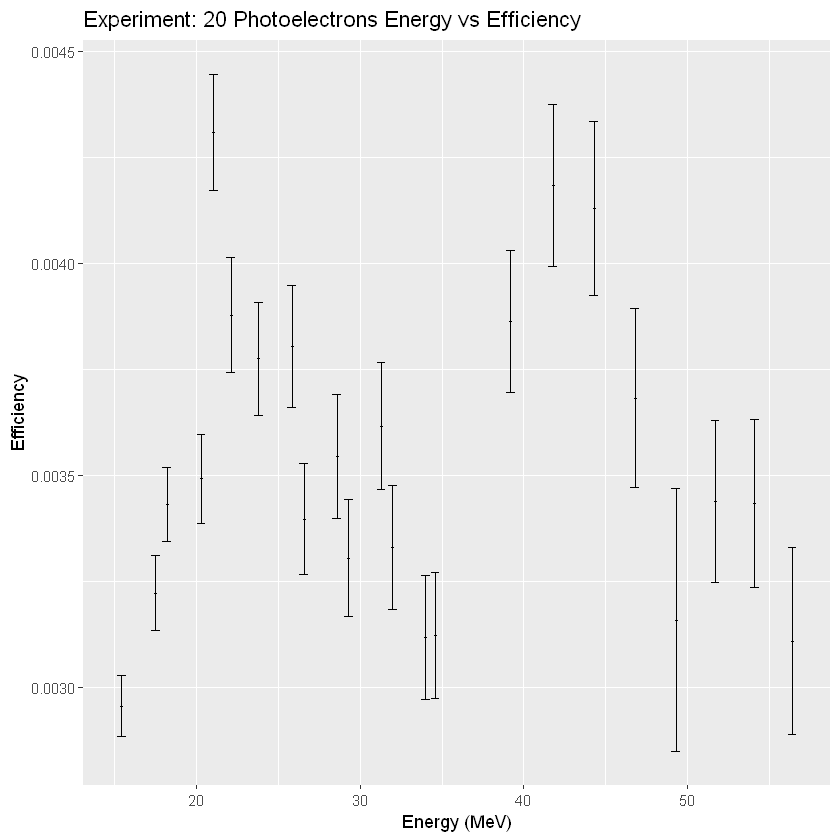

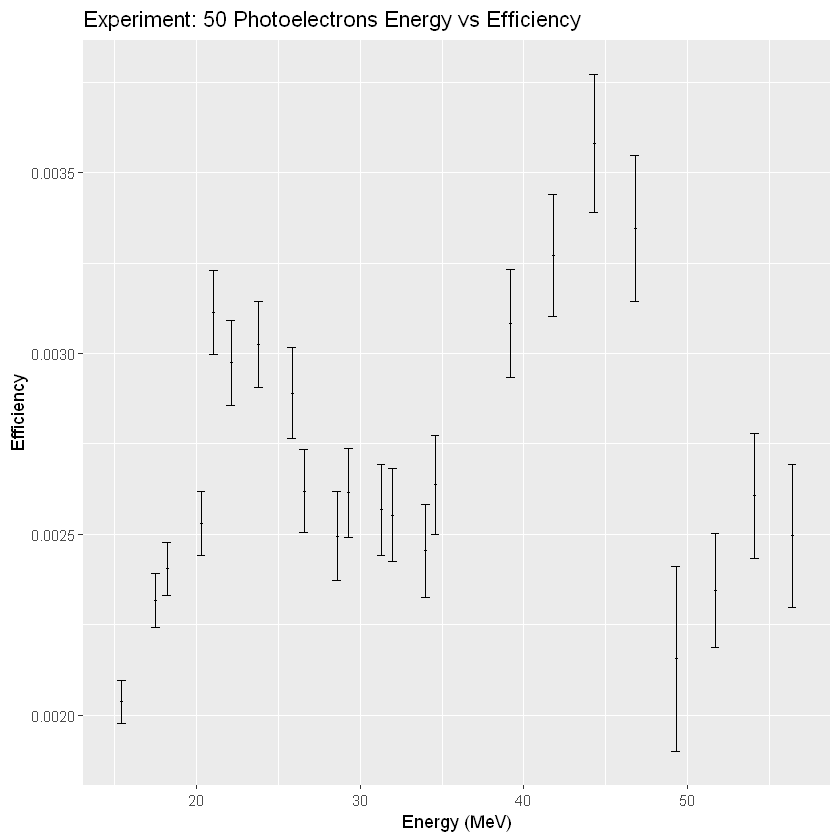

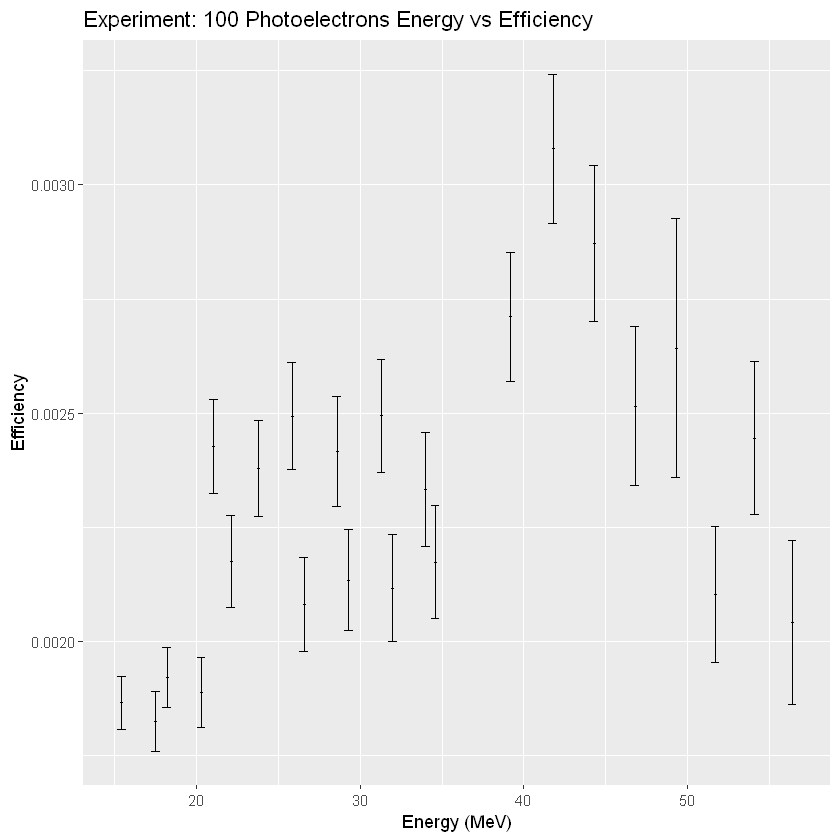

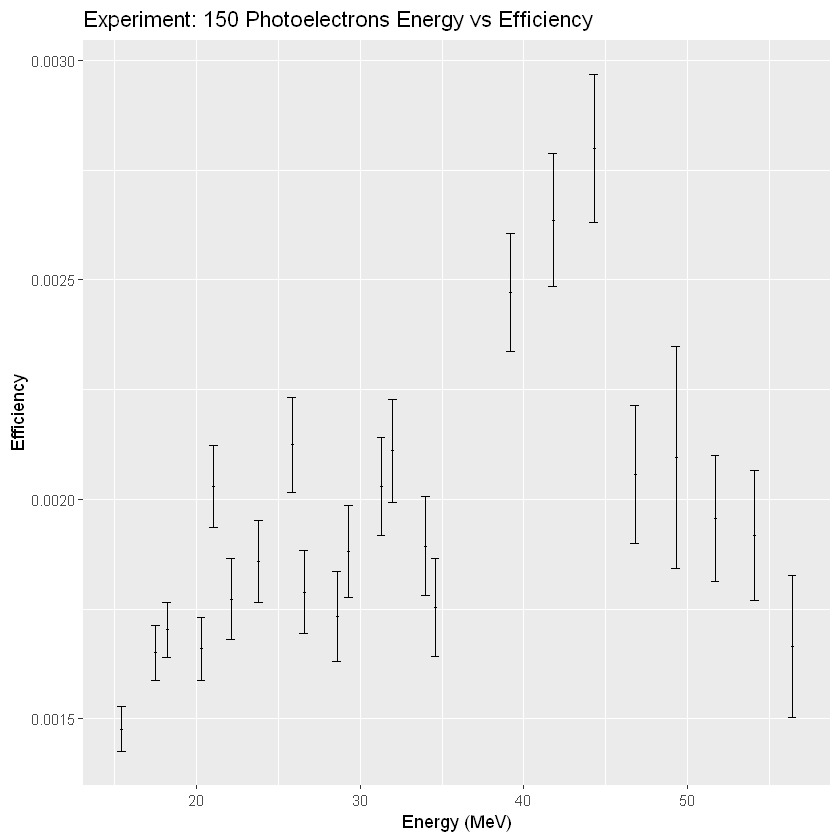

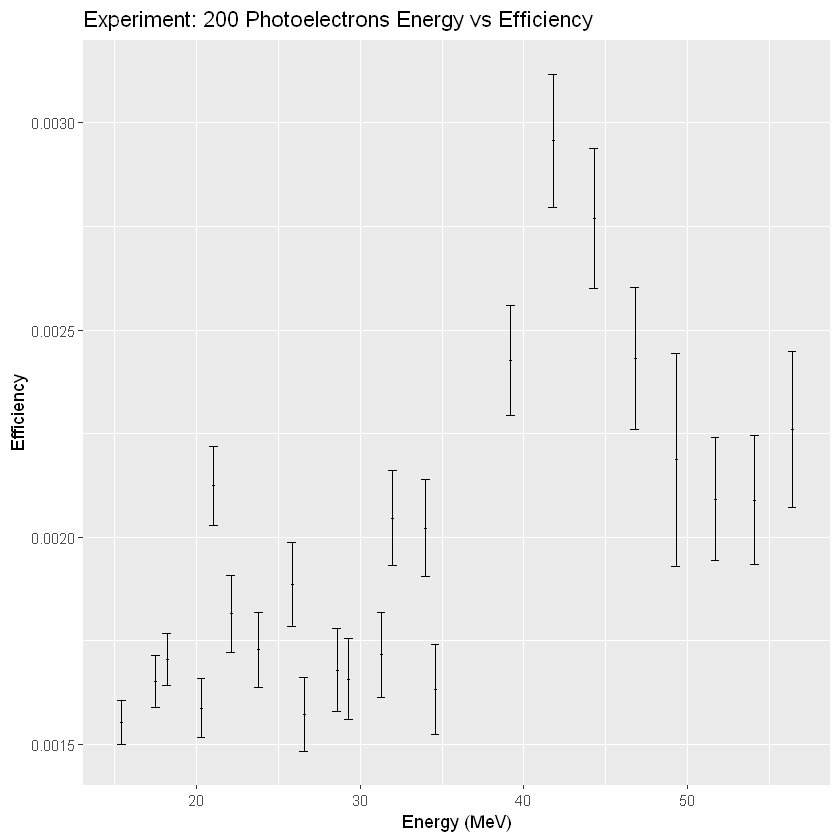

In [40]:
pl_prt_nPE(df_comb_exp_all, 2, "exp")
pl_prt_nPE(df_comb_exp_all, 10, "exp")
pl_prt_nPE(df_comb_exp_all, 20, "exp")
pl_prt_nPE(df_comb_exp_all, 50, "exp")
pl_prt_nPE(df_comb_exp_all, 100, "exp")
pl_prt_nPE(df_comb_exp_all, 150, "exp")
pl_prt_nPE(df_comb_exp_all, 200, "exp")

# 3D Efficiency plot

Overall efficiencies are all together plotted as a 3D heatmap. 

In [41]:
library(plot3D)
library(reshape2)


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths



In [42]:
df_eff_all_ord <- df_comb_exp_all[order(df_comb_exp_all$Photoelectrons, df_comb_exp_all$Energy),] 
head(df_eff_all_ord, n = 23)

df_sim_all_ord <- df_comb_sim[order(df_comb_sim$Photoelectrons, df_comb_sim$Energy),] 
head(df_sim_all_ord, n = 23)

,Photoelectrons,Efficiency,error,ymin,ymax,Energy
666,2,0.7397680,0.001510532,0.7382574,0.7412785,15.43
835,2,0.7181013,0.001716587,0.7163847,0.7198179,17.52
1002,2,0.7110424,0.001659815,0.7093826,0.7127022,18.21
1171,2,0.7113256,0.001952267,0.7093733,0.7132779,20.31
1,2,0.6524848,0.002157622,0.6503272,0.6546424,21.06
167,2,0.6713330,0.002303191,0.6690298,0.6736362,22.11
335,2,0.6742632,0.002299367,0.6719638,0.6765625,23.80
501,2,0.6669274,0.002457505,0.6644699,0.6693849,25.85
1339,2,0.6972769,0.002441828,0.6948350,0.6997187,26.58
1505,2,0.7121053,0.002704026,0.7094013,0.7148093,28.60


,Photoelectrons,Efficiency,error,ymin,ymax,Energy
2,2,0.001798,4.24028e-05,0.0017555972,0.0018404028,Sim.15MeV
210,2,0.001480,3.84708e-05,0.0014415292,0.0015184708,Sim.20MeV
212,2,0.001270,3.56371e-05,0.0012343629,0.0013056371,Sim.25MeV
214,2,0.001130,3.36155e-05,0.0010963845,0.0011636155,Sim.30MeV
216,2,0.001035,3.21714e-05,0.0010028286,0.0010671714,Sim.35MeV
218,2,0.000992,3.14960e-05,0.0009605040,0.0010234960,Sim.40MeV
220,2,0.000974,3.12090e-05,0.0009427910,0.0010052090,Sim.50MeV
3,4,0.001726,4.15452e-05,0.0016844548,0.0017675452,Sim.15MeV
310,4,0.001403,3.74566e-05,0.0013655434,0.0014404566,Sim.20MeV
312,4,0.001263,3.55387e-05,0.0012274613,0.0012985387,Sim.25MeV


In [43]:
eff_mat_exp <- acast(df_eff_all_ord, Photoelectrons ~ Energy, value.var = "Efficiency")
eff_mat_sim <- acast(df_sim_all_ord, Photoelectrons ~ Energy, value.var = "Efficiency")

## Simulation

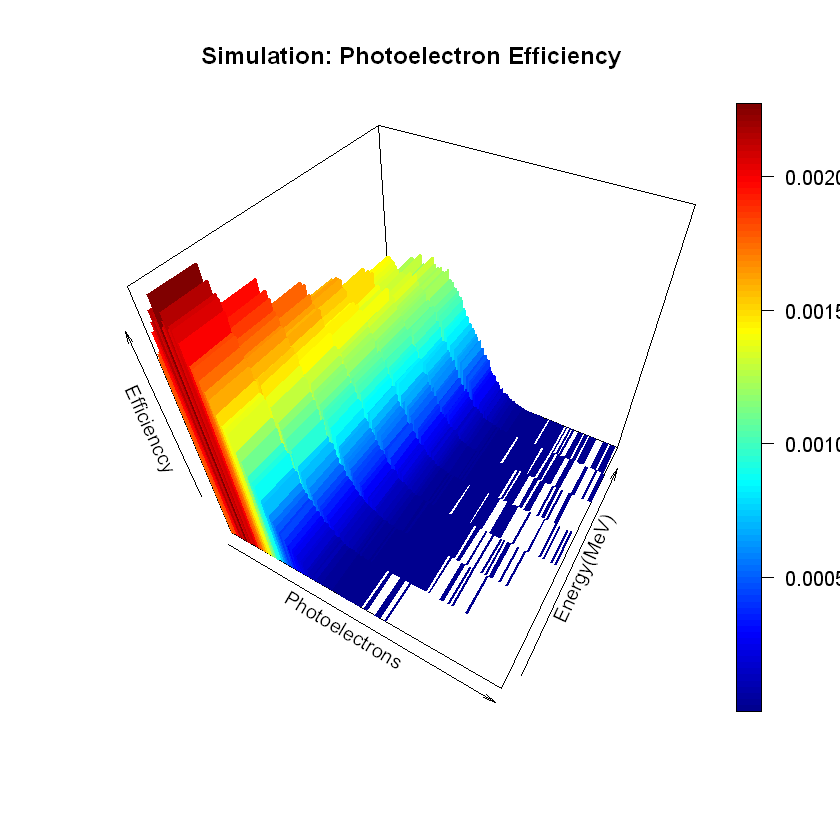

In [45]:
pesrt <- 5
peend <- 150

eff_mat_3d <- eff_mat_sim[pesrt:peend,]
sim_eng <-c(15,20,25,30,35,40,50)
hist3D(x = seq(1, 2, length.out = nrow(eff_mat_3d)), 
      y = seq(1, 2, length.out = ncol(eff_mat_3d)), 
      z = eff_mat_3d,
#       xticks= seq(5,150, by = 5),
      phi = 45, theta = 30,
#       lable = TRUE,
#        ticktype = "detailed",
      xlab = "Photoelectrons", ylab = "Energy(MeV)", zlab = "Efficienccy",
      main = "Simulation: Photoelectron Efficiency")

# Use text3D to label x axis
 text3D(x = seq(1,7, by = 1), y = seq(1,7, by = 1),z = seq(1,7, by = 1),
       labels = sim_eng,
       add = TRUE, adj = 0)

## Experiment

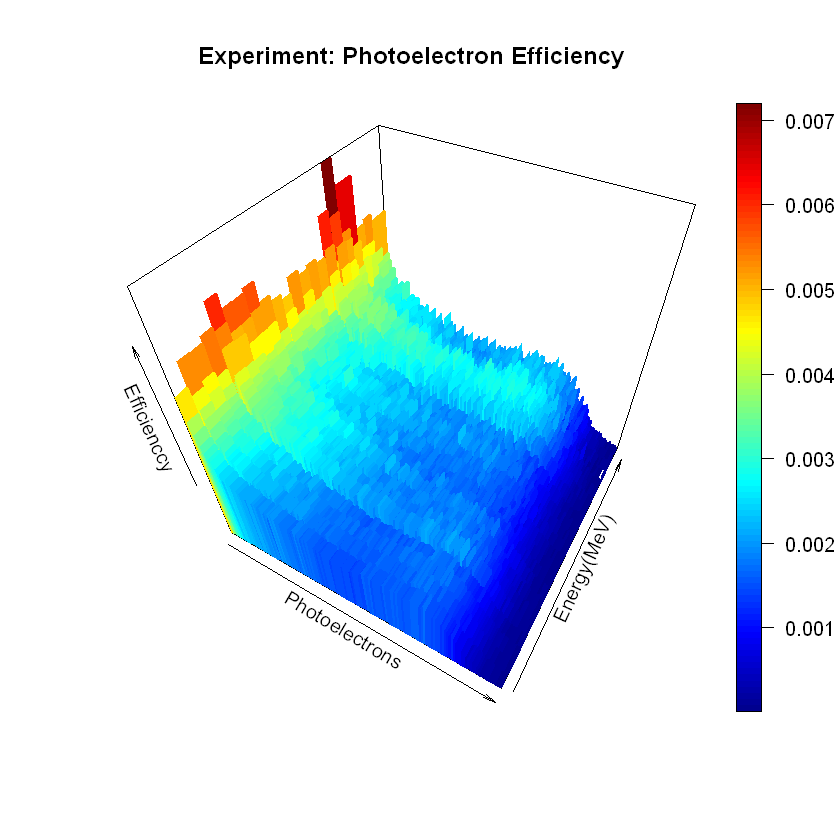

In [46]:
pesrt <- 5
peend <- 150

eff_mat_3d <- eff_mat_exp[pesrt:peend,]
hist3D(x = seq(1, 2, length.out = nrow(eff_mat_3d)), 
      y = seq(1, 2, length.out = ncol(eff_mat_3d)), 
      z = eff_mat_3d,
      phi = 45, theta = 30,
      xlab = "Photoelectrons", ylab = "Energy(MeV)", zlab = "Efficienccy",
      main = "Experiment: Photoelectron Efficiency")

# Use text3D to label x axis
#  text3D(x = seq(1,7, by = 1), y = seq(1,7, by = 1),z = seq(1,7, by = 1),
#        labels = sim_eng,
#        add = TRUE, adj = 0)